In [1]:
library(tidyverse)
library(here)
library(glue)
library(furrr)
library(cowplot)
library(lemon)

devtools::load_all(".")

plan(multiprocess, workers = 30)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /mnt/expressions/mp/ychr

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: future

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%

Loading ychr


In [2]:
read_trajectories <- function(scenario, scaling, gene_totals, admix_rates, admix_times, reps) {
    future_map_dfr(reps, function(rep) {
    map_dfr(sprintf("%d", scaling), function(scale) {
    map_dfr(sprintf("%d", gene_totals), function(gene_total) {
    map_dfr(sprintf("%0.2f", admix_rates), function(admix_rate) {
    map_dfr(sprintf("%d", admix_times), function(admix_time) {

        f <- here(glue("data/sim/{scenario}/dfe{scale}_seq{gene_total}_time{admix_time}_rate{admix_rate}_rep{rep}_traj.tsv"))

        read_tsv(f, col_types = "id") %>%
            mutate(dfe = as.numeric(scale),
                   gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   admix_rate = as.numeric(admix_rate),
                   rep = rep,
                   time = gen * 25)

    })
    })
    })
    })
    })
}

In [3]:
m2n_traj <- read_trajectories(
    scenario = "dfe_scaling",
    scaling = c(1, 10, 50, 100),
    gene_totals = seq(100000, 2000000, 100000),
    admix_rates = 0.03,
    admix_times = seq(200000, 450000, 25000),
    reps = 1:20
)

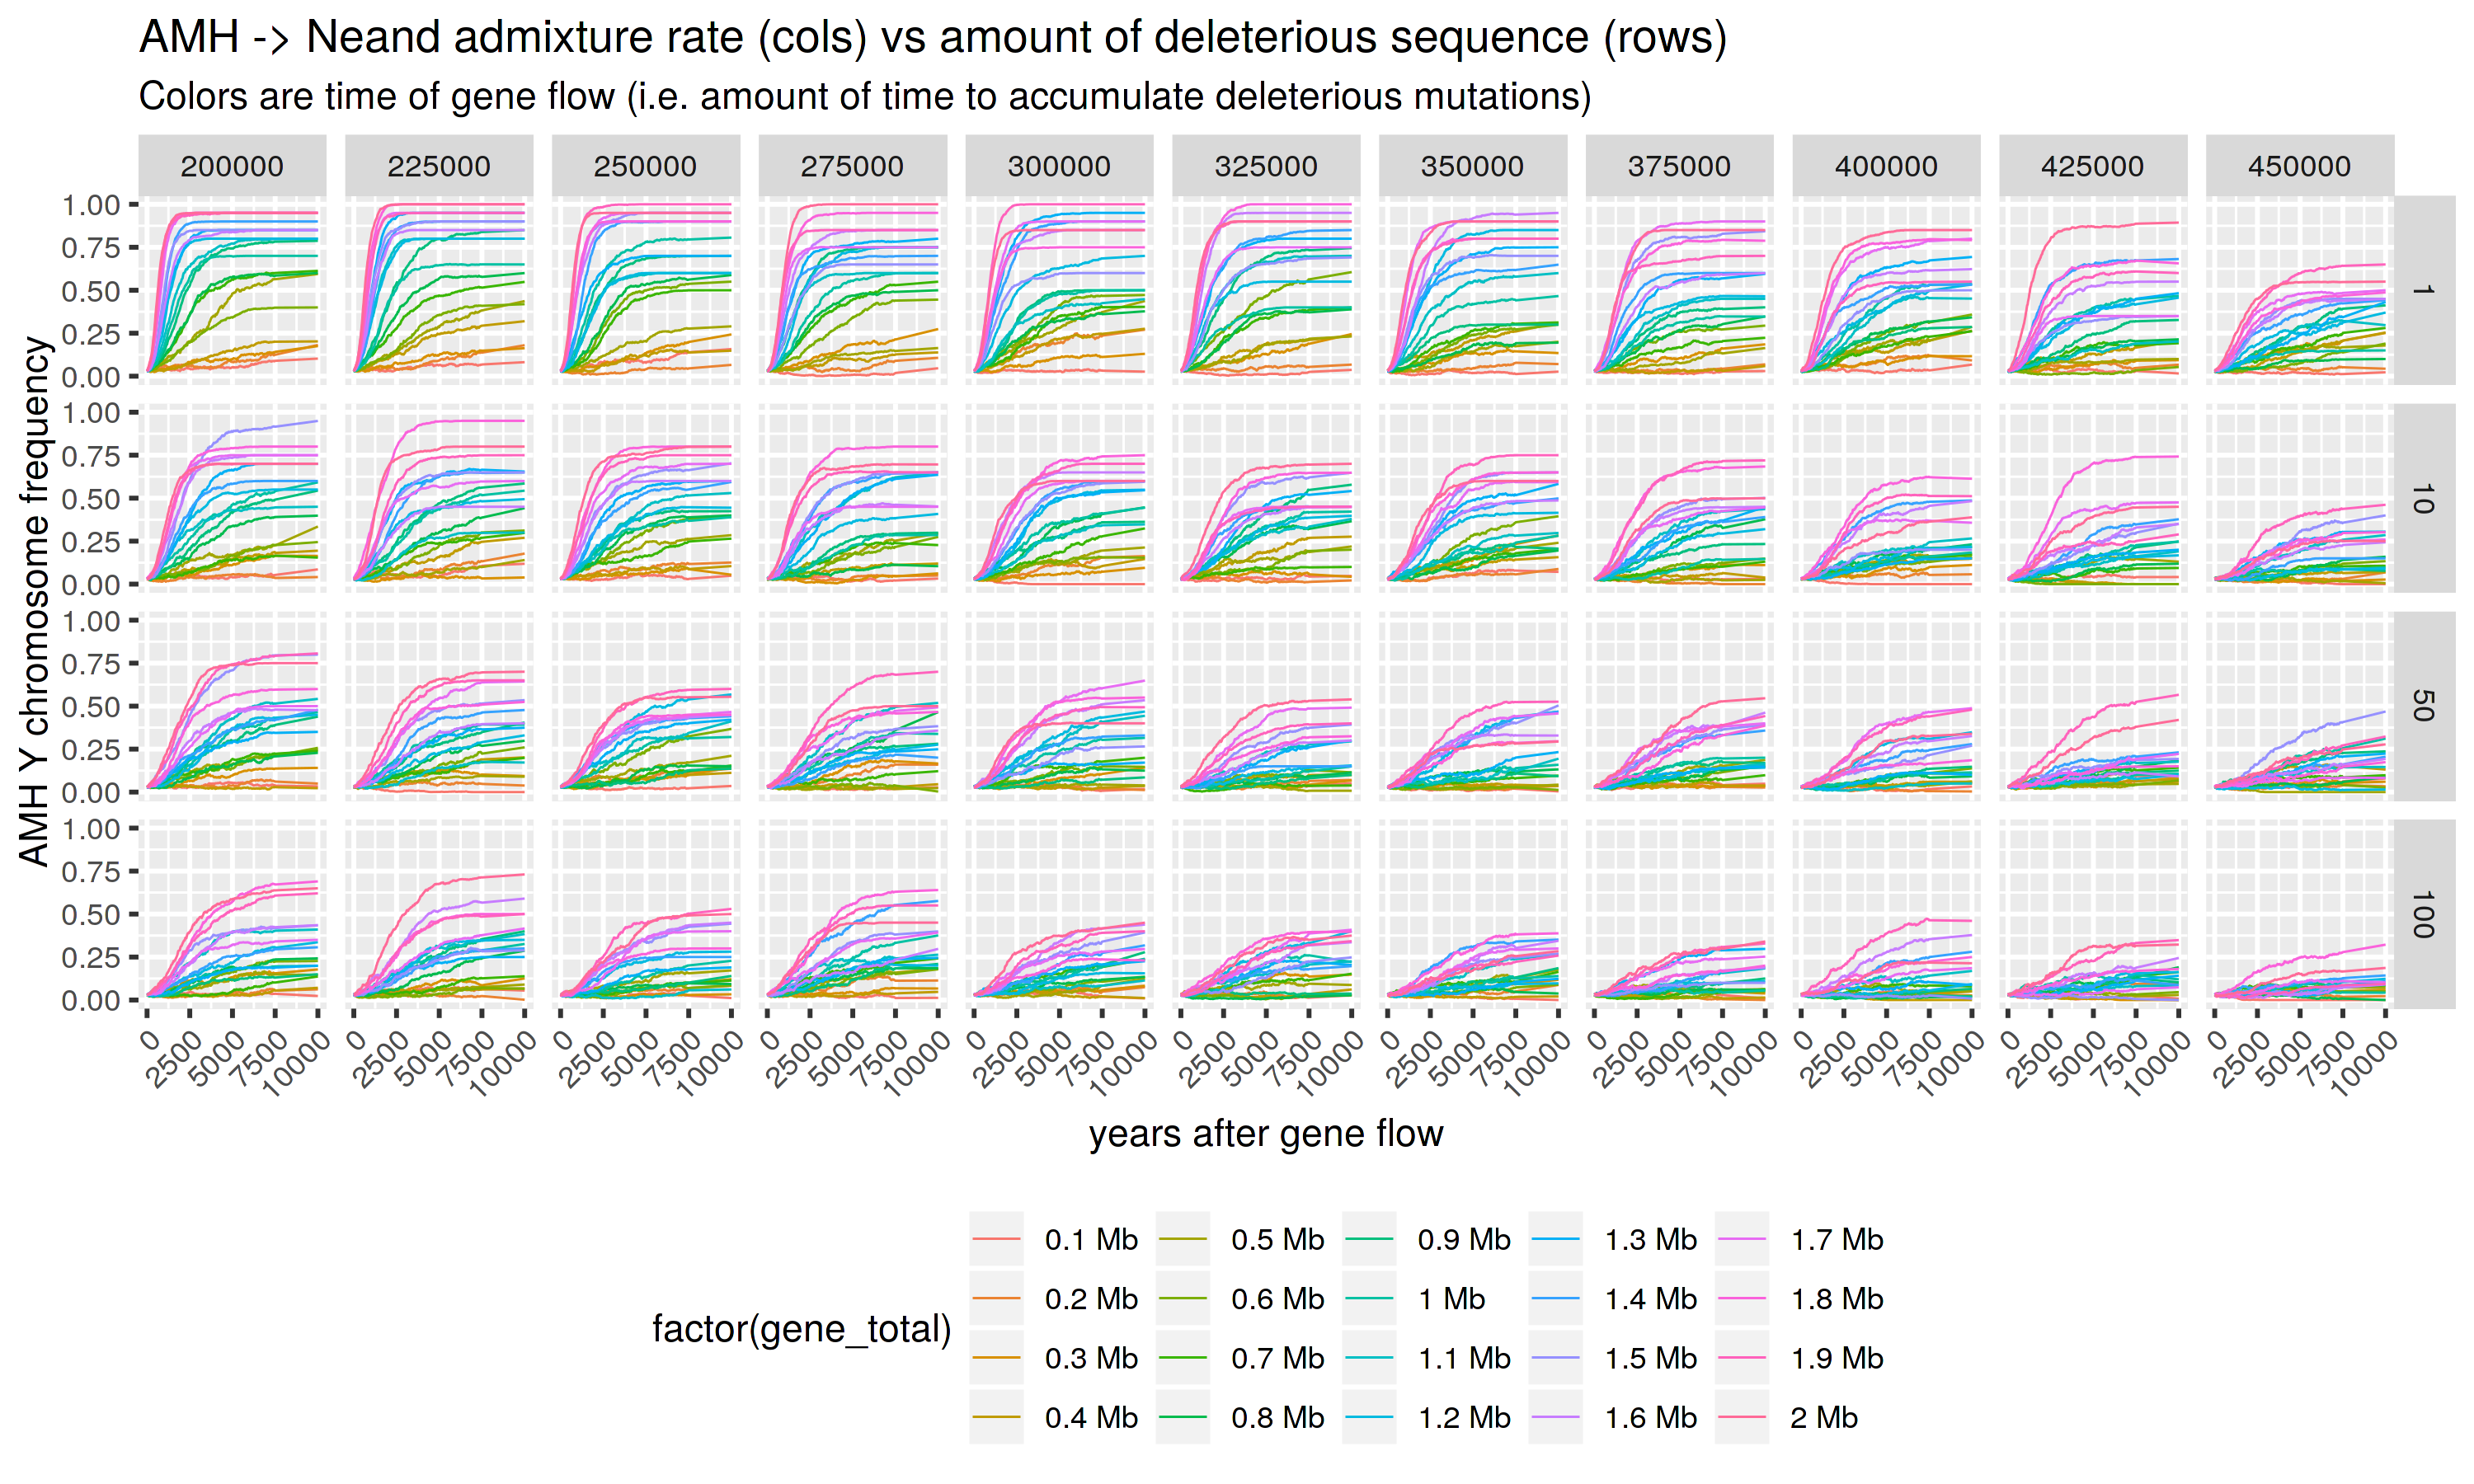

In [4]:
set_dim(10, 6)

m2n_traj %>%
filter(gen < 500) %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(gen, time, dfe, gene_total, admix_time, admix_rate) %>%
summarise(ancestry = mean(ancestry)) %>%
ggplot(aes(time, ancestry, color = factor(gene_total))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("AMH Y chromosome frequency") +
    facet_grid(dfe ~ admix_time) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

In [5]:
read_fitness <- function(scenario, scaling, gene_totals, admix_rates, admix_times, reps) {
    future_map_dfr(reps, function(rep) {
    map_dfr(sprintf("%d", scaling), function(scale) {
    map_dfr(sprintf("%d", gene_totals), function(gene_total) {
    map_dfr(sprintf("%0.2f", admix_rates), function(admix_rate) {
    map_dfr(sprintf("%d", admix_times), function(admix_time) {

        f <- here(glue("data/sim/{scenario}/dfe{scale}_seq{gene_total}_time{admix_time}_rate{admix_rate}_rep{rep}_pop.txt.gz"))

        read_slim(f) %>%
            calculate_fitness %>%
            mutate(dfe = as.numeric(scale),
                   gene_total = as.integer(gene_total),
                   admix_time = as.integer(admix_time),
                   admix_rate = as.numeric(admix_rate),
                   rep = rep)

    })
    })
    })
    })
    }) %>%
    mutate(pop = case_when(pop == "p1" ~ "AMH", pop == "p2" ~ "Neanderthals"))
}

In [18]:
fitness <- read_fitness(
    scenario = "dfe_scaling",
    scaling = c(1:5, 10, 50, 100),
    gene_totals = seq(100000, 2000000, 100000),
    admix_rates = 0.03,
    admix_times = seq(200000, 450000, 25000),
    reps = 1:20
)

Calculate average fitness for each genome across all replicates:

In [19]:
mean_fitness <- fitness %>%
    group_by(genome_id, pop, dfe, gene_total, admix_time, admix_rate) %>%
    summarise(fitness = mean(fitness))

In [20]:
head(mean_fitness)

genome_id pop dfe gene_total admix_time admix_rate fitness  
1 p1:10001  AMH 1   100000     200000     0.03       0.9991882
2 p1:10001  AMH 1   100000     225000     0.03       0.9982566
3 p1:10001  AMH 1   100000     250000     0.03       0.9973926
4 p1:10001  AMH 1   100000     275000     0.03       0.9992129
5 p1:10001  AMH 1   100000     300000     0.03       0.9989371
6 p1:10001  AMH 1   100000     325000     0.03       0.9975815

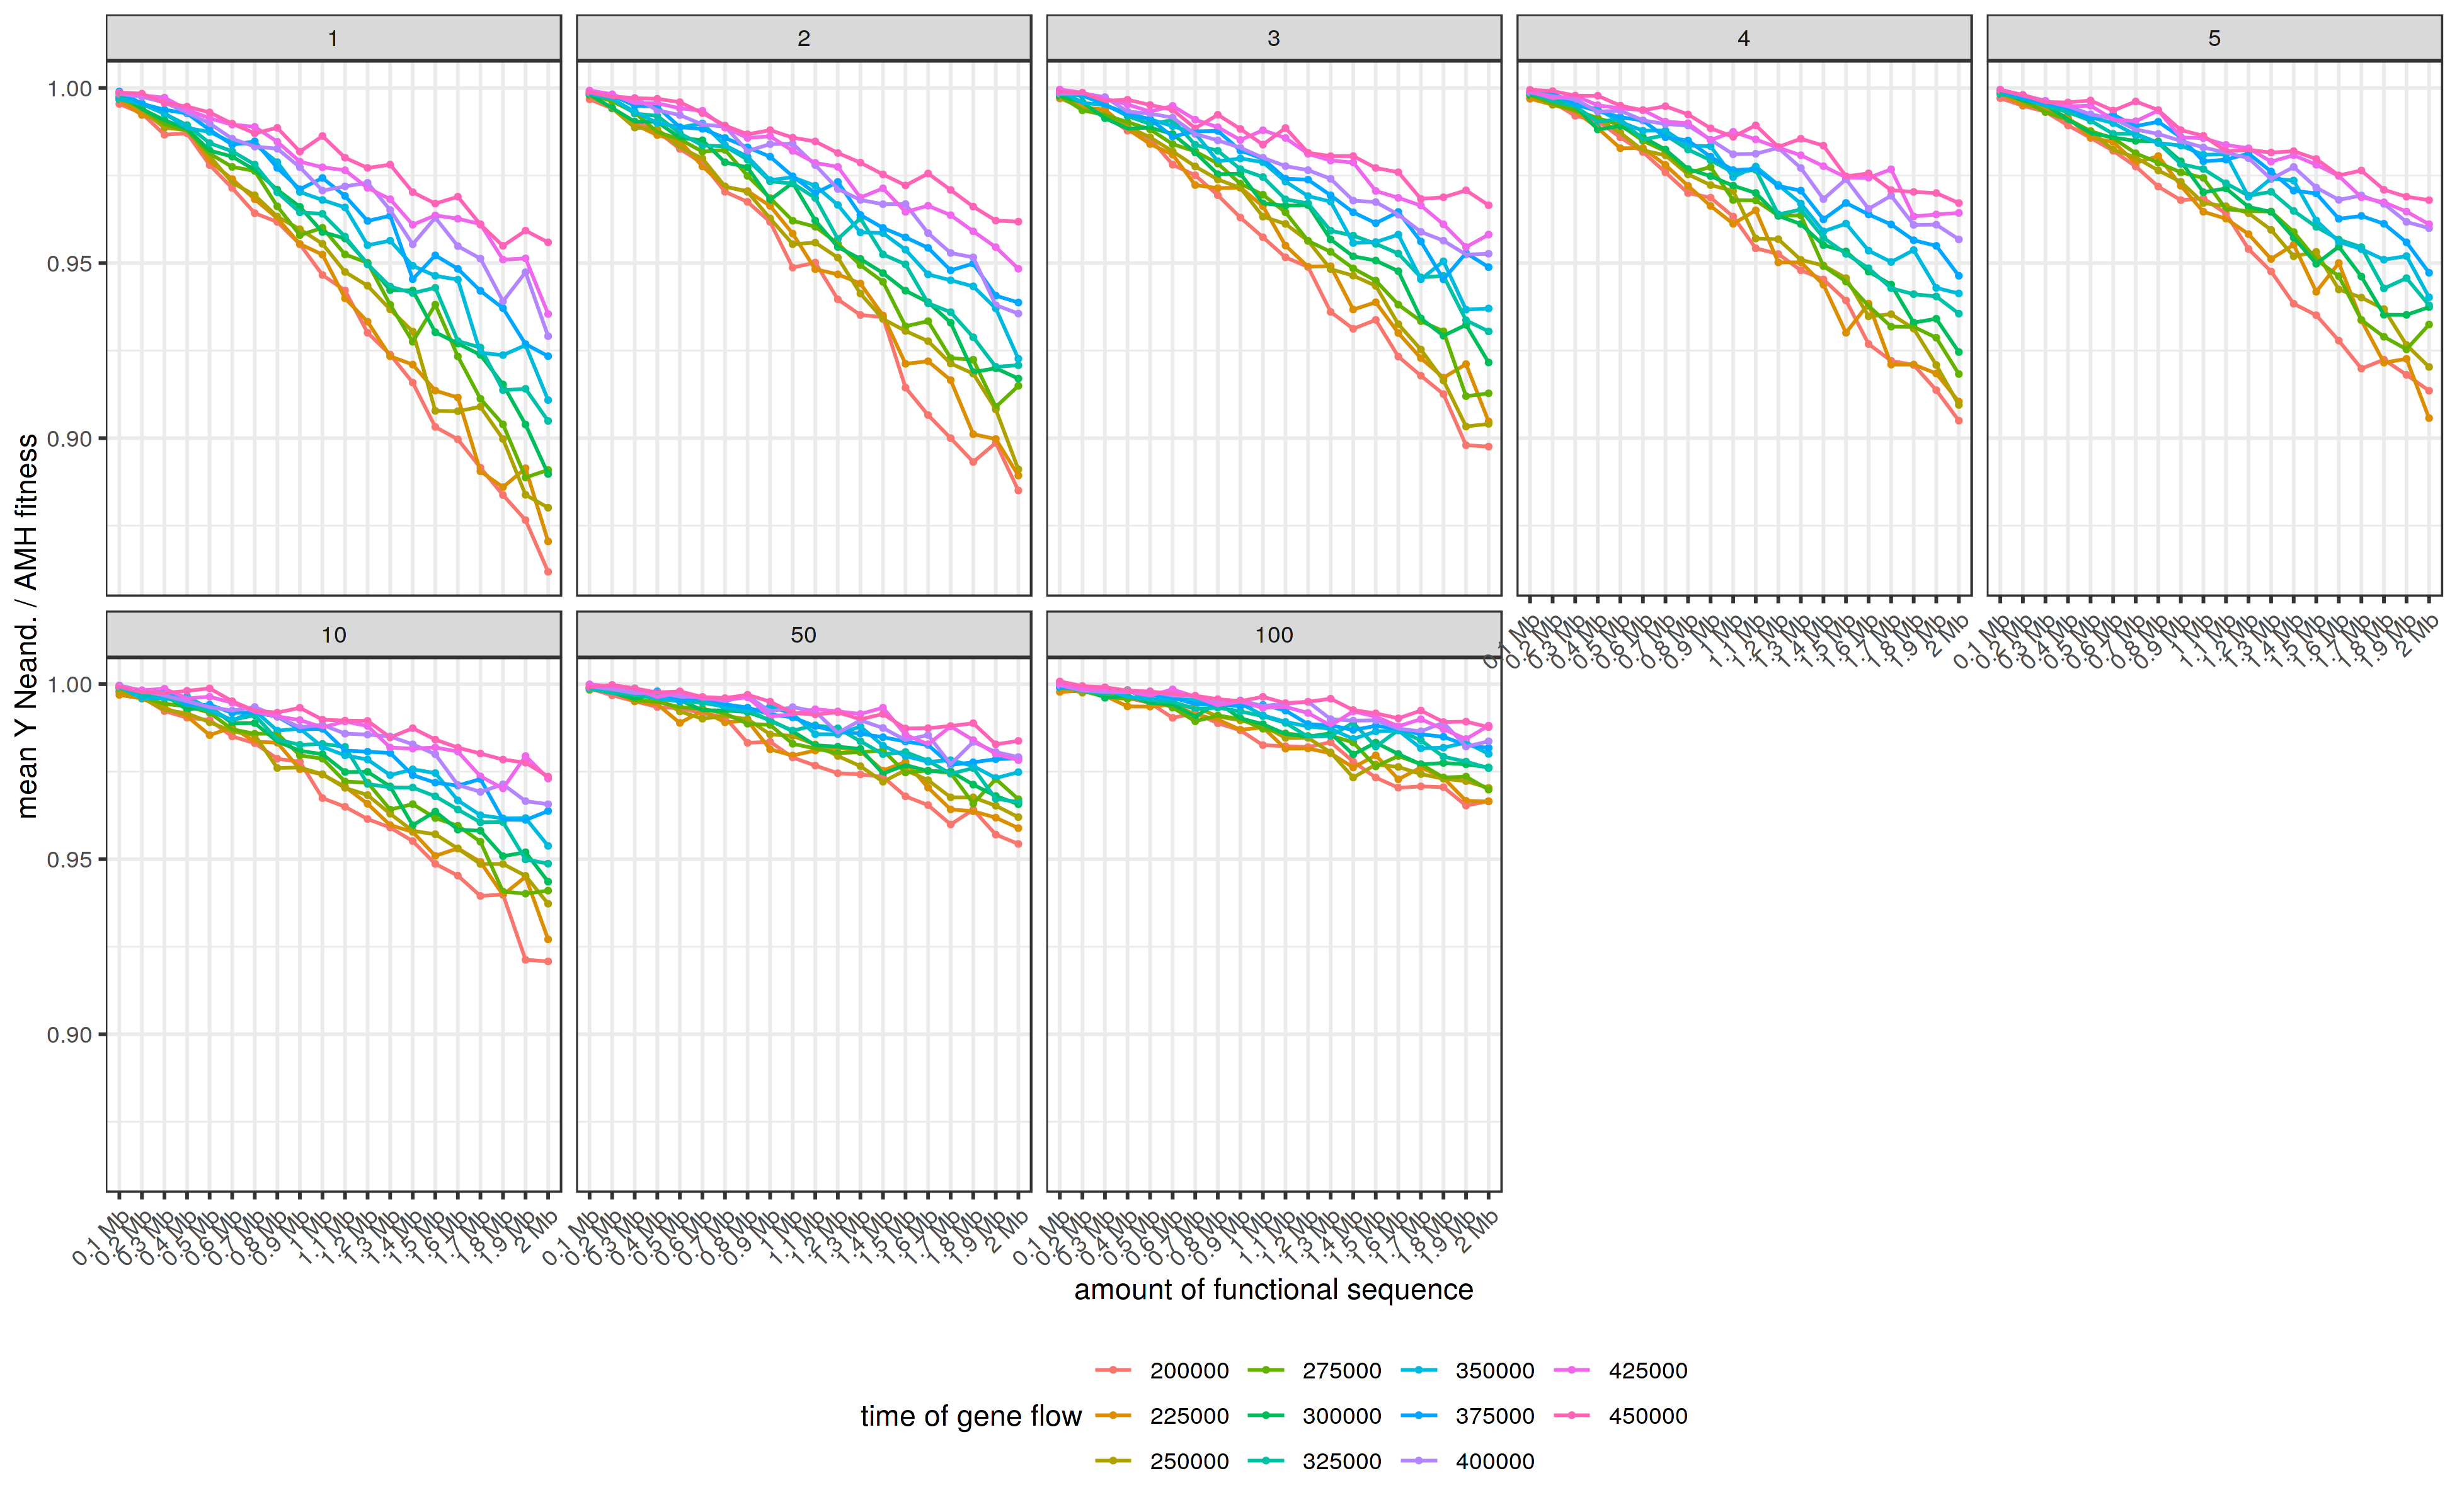

In [24]:
set_dim(13, 8)

mean_fitness %>%
ungroup %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(pop, dfe, gene_total, admix_time, admix_rate) %>%
summarise(fitness = mean(fitness)) %>%
spread(pop, fitness) %>%
mutate(ratio = Neanderthals / AMH) %>%
ggplot(aes(factor(gene_total), ratio, color = factor(admix_time), group = factor(admix_time))) +
    geom_point(size = 1/2) +
    geom_line(size = 1/2) +
    theme_bw() +
    facet_wrap(~ dfe, ncol = 5) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45)) +
    labs(color = "time of gene flow",
         y = "mean Y Neand. / AMH fitness",
         x = "amount of functional sequence")

Annotate each replicate trajectory with the value of Neanderthal and AMH loads prior to the gene flow event:

In [13]:
traj_fitness <- fitness %>%
    group_by(pop, rep, gene_total, admix_time, admix_rate) %>%
    summarise_if(is.numeric, mean) %>%
    select(-S) %>%
    spread(pop, fitness) %>%
    mutate(ratio = 1 - Neanderthals / AMH) %>%
    inner_join(m2n_traj) %>% mutate(time = gen * 25)

Joining, by = c("rep", "gene_total", "admix_time", "admix_rate")


In [14]:
head(traj_fitness)

rep gene_total admix_time admix_rate AMH       Neanderthals ratio       gen
1 1   100000     200000     0.05       0.9977743 0.9923883    0.005398003 0  
2 1   100000     200000     0.05       0.9977743 0.9923883    0.005398003 1  
3 1   100000     200000     0.05       0.9977743 0.9923883    0.005398003 2  
4 1   100000     200000     0.05       0.9977743 0.9923883    0.005398003 3  
5 1   100000     200000     0.05       0.9977743 0.9923883    0.005398003 4  
6 1   100000     200000     0.05       0.9977743 0.9923883    0.005398003 5  
  ancestry time
1 0.036      0 
2 0.038     25 
3 0.026     50 
4 0.032     75 
5 0.038    100 
6 0.046    125

Assign trajectories to bins based on the relative Neand/AMH fitness:

In [15]:
mean_traj_fitness <- traj_fitness %>%
    group_by(gen, time, gene_total, admix_time, admix_rate) %>%
    summarise(ancestry = mean(ancestry),
              ratio = mean(ratio))

In [16]:
min(mean_traj_fitness$ratio)

[1] 0.0008346513

In [17]:
max(mean_traj_fitness$ratio)

[1] 0.1365733

In [18]:
(boundaries <- seq(0, 0.14, 0.01))

[1] 0.00 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.10 0.11 0.12 0.13 0.14

In [19]:
mean_traj_fitness <- mean_traj_fitness %>% mutate(fitness_bin = cut(ratio, boundaries))

In [20]:
mean_traj_fitness$fitness_bin %>% table

.
   (0,0.01] (0.01,0.02] (0.02,0.03] (0.03,0.04] (0.04,0.05] (0.05,0.06] 
      13520       10478        9126        8112        7774        5746 
(0.06,0.07] (0.07,0.08] (0.08,0.09]  (0.09,0.1]  (0.1,0.11] (0.11,0.12] 
       5070        3718        3718        2704        1690        1352 
(0.12,0.13] (0.13,0.14] 
        676         676 

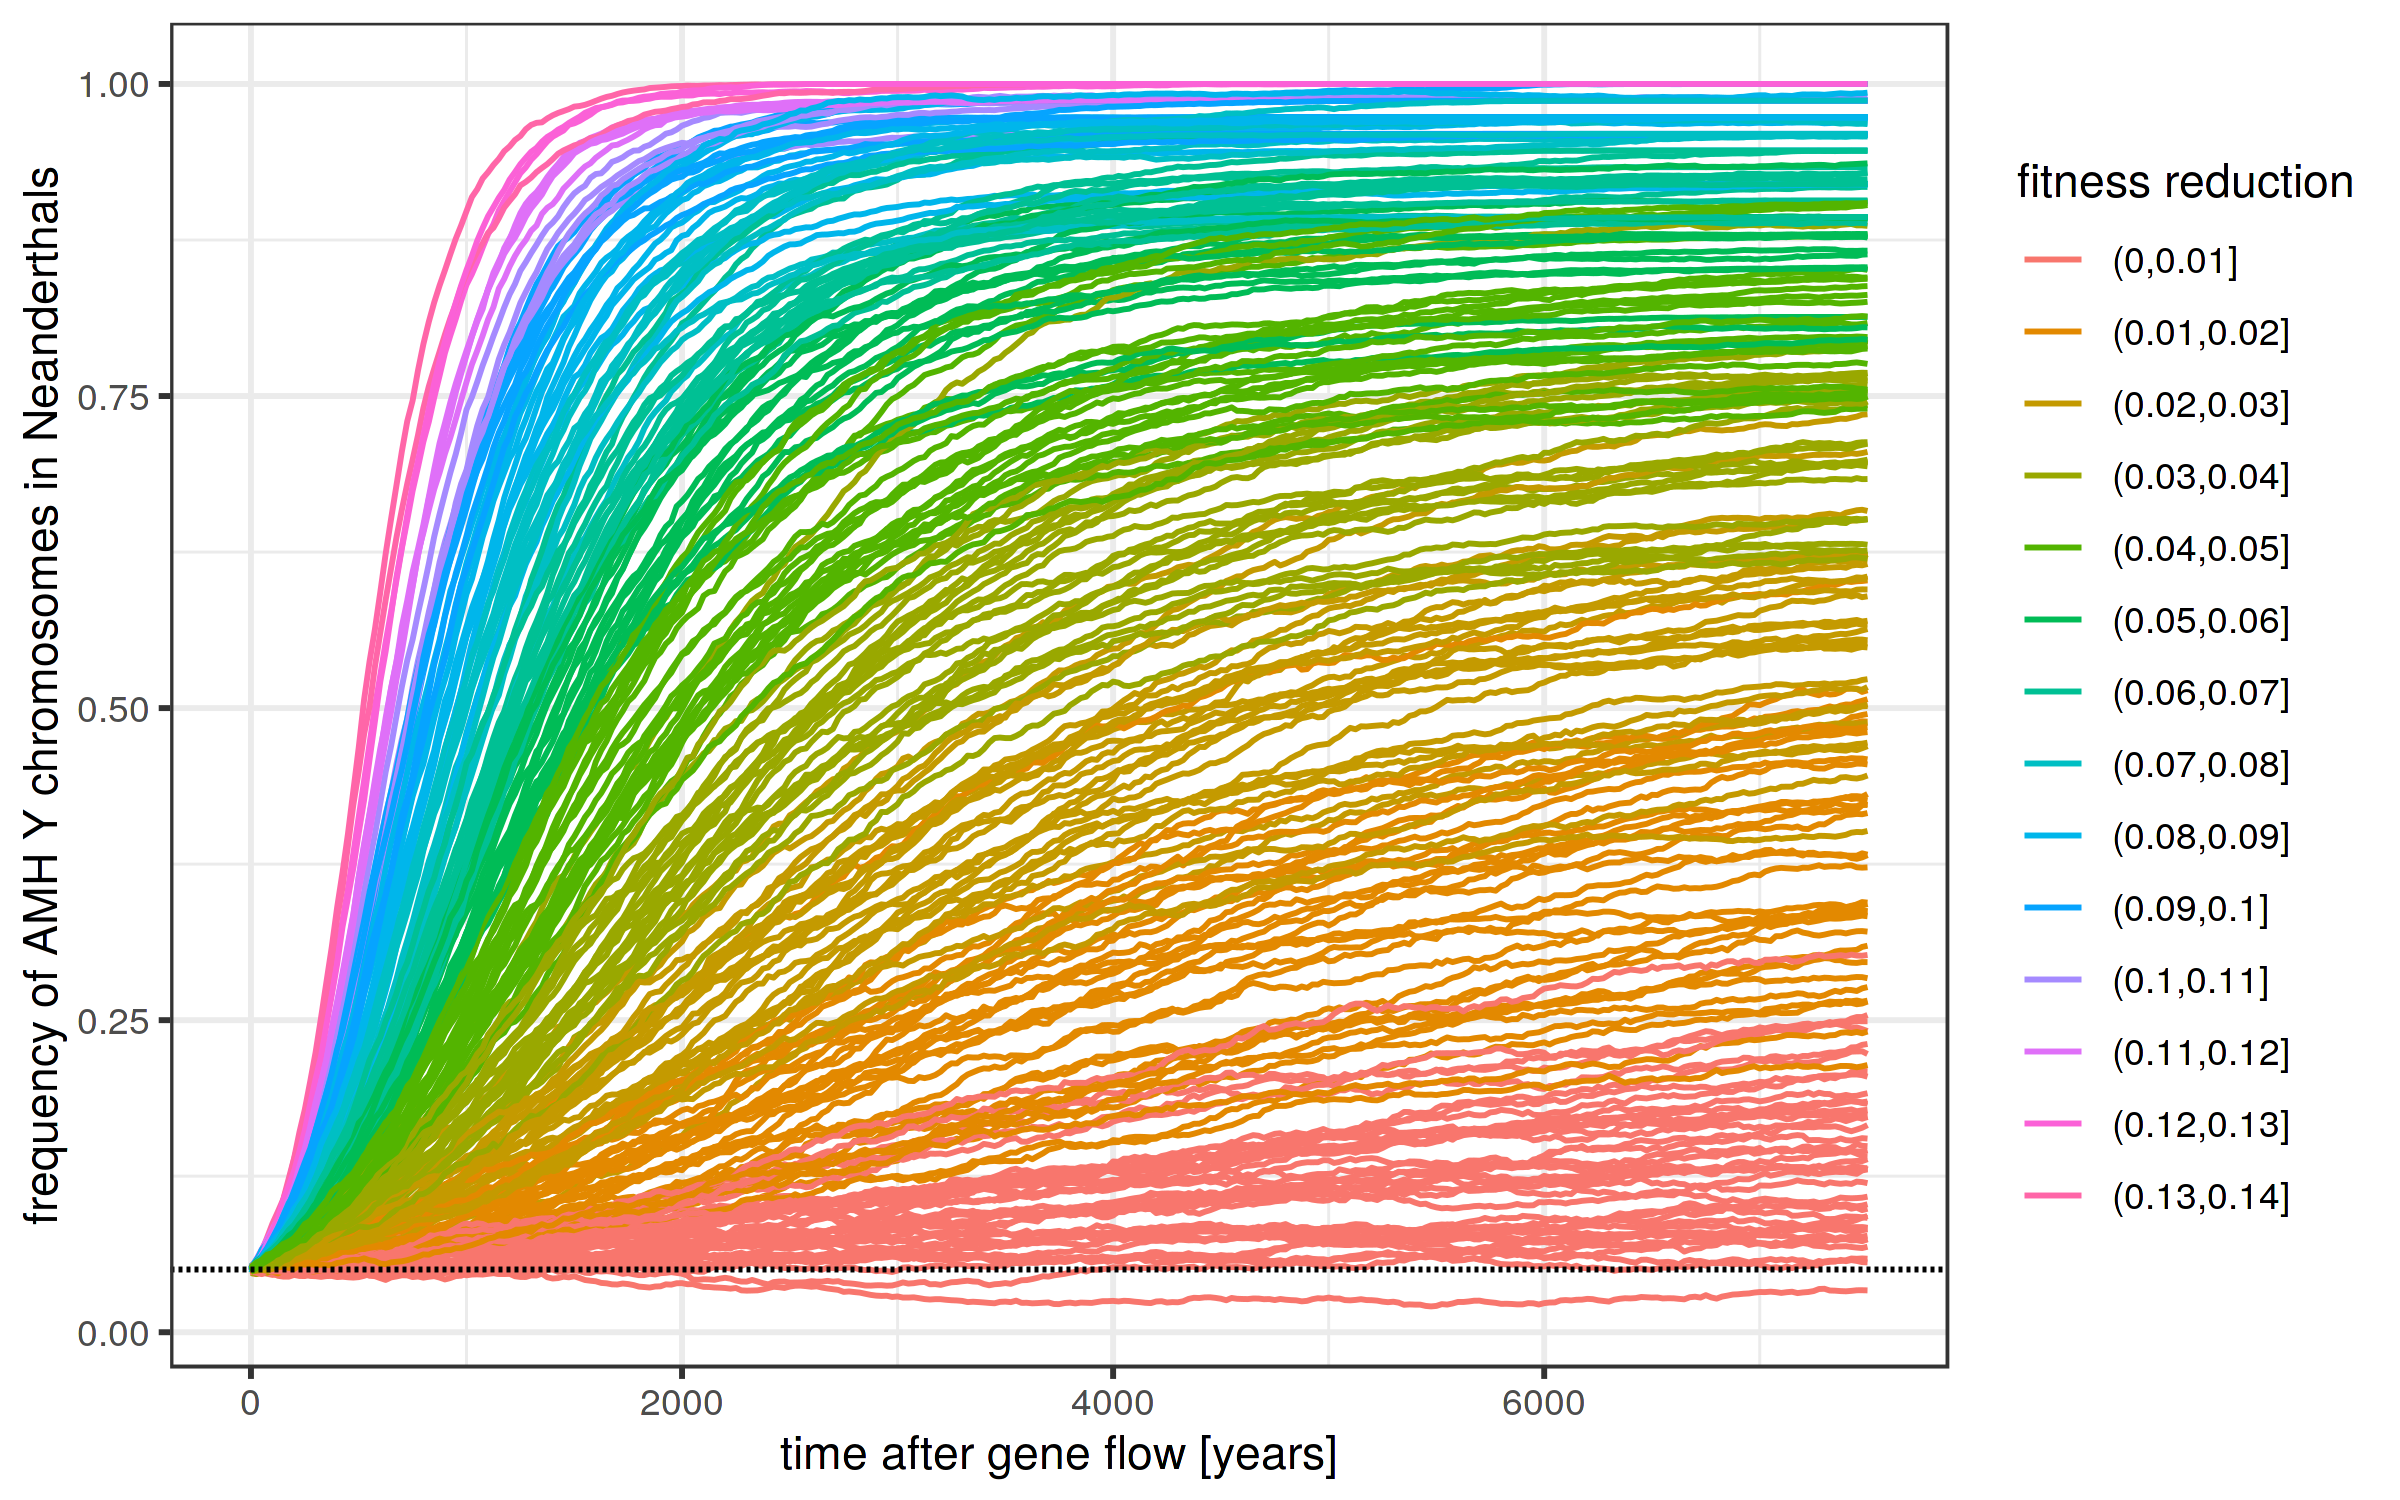

In [21]:
set_dim(8, 5)

mean_traj_fitness %>%
filter(gen < 400) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    geom_hline(yintercept = 0.05, linetype = 2) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "frequency of AMH Y chromosomes in Neanderthals",
         x = "time after gene flow [years]")

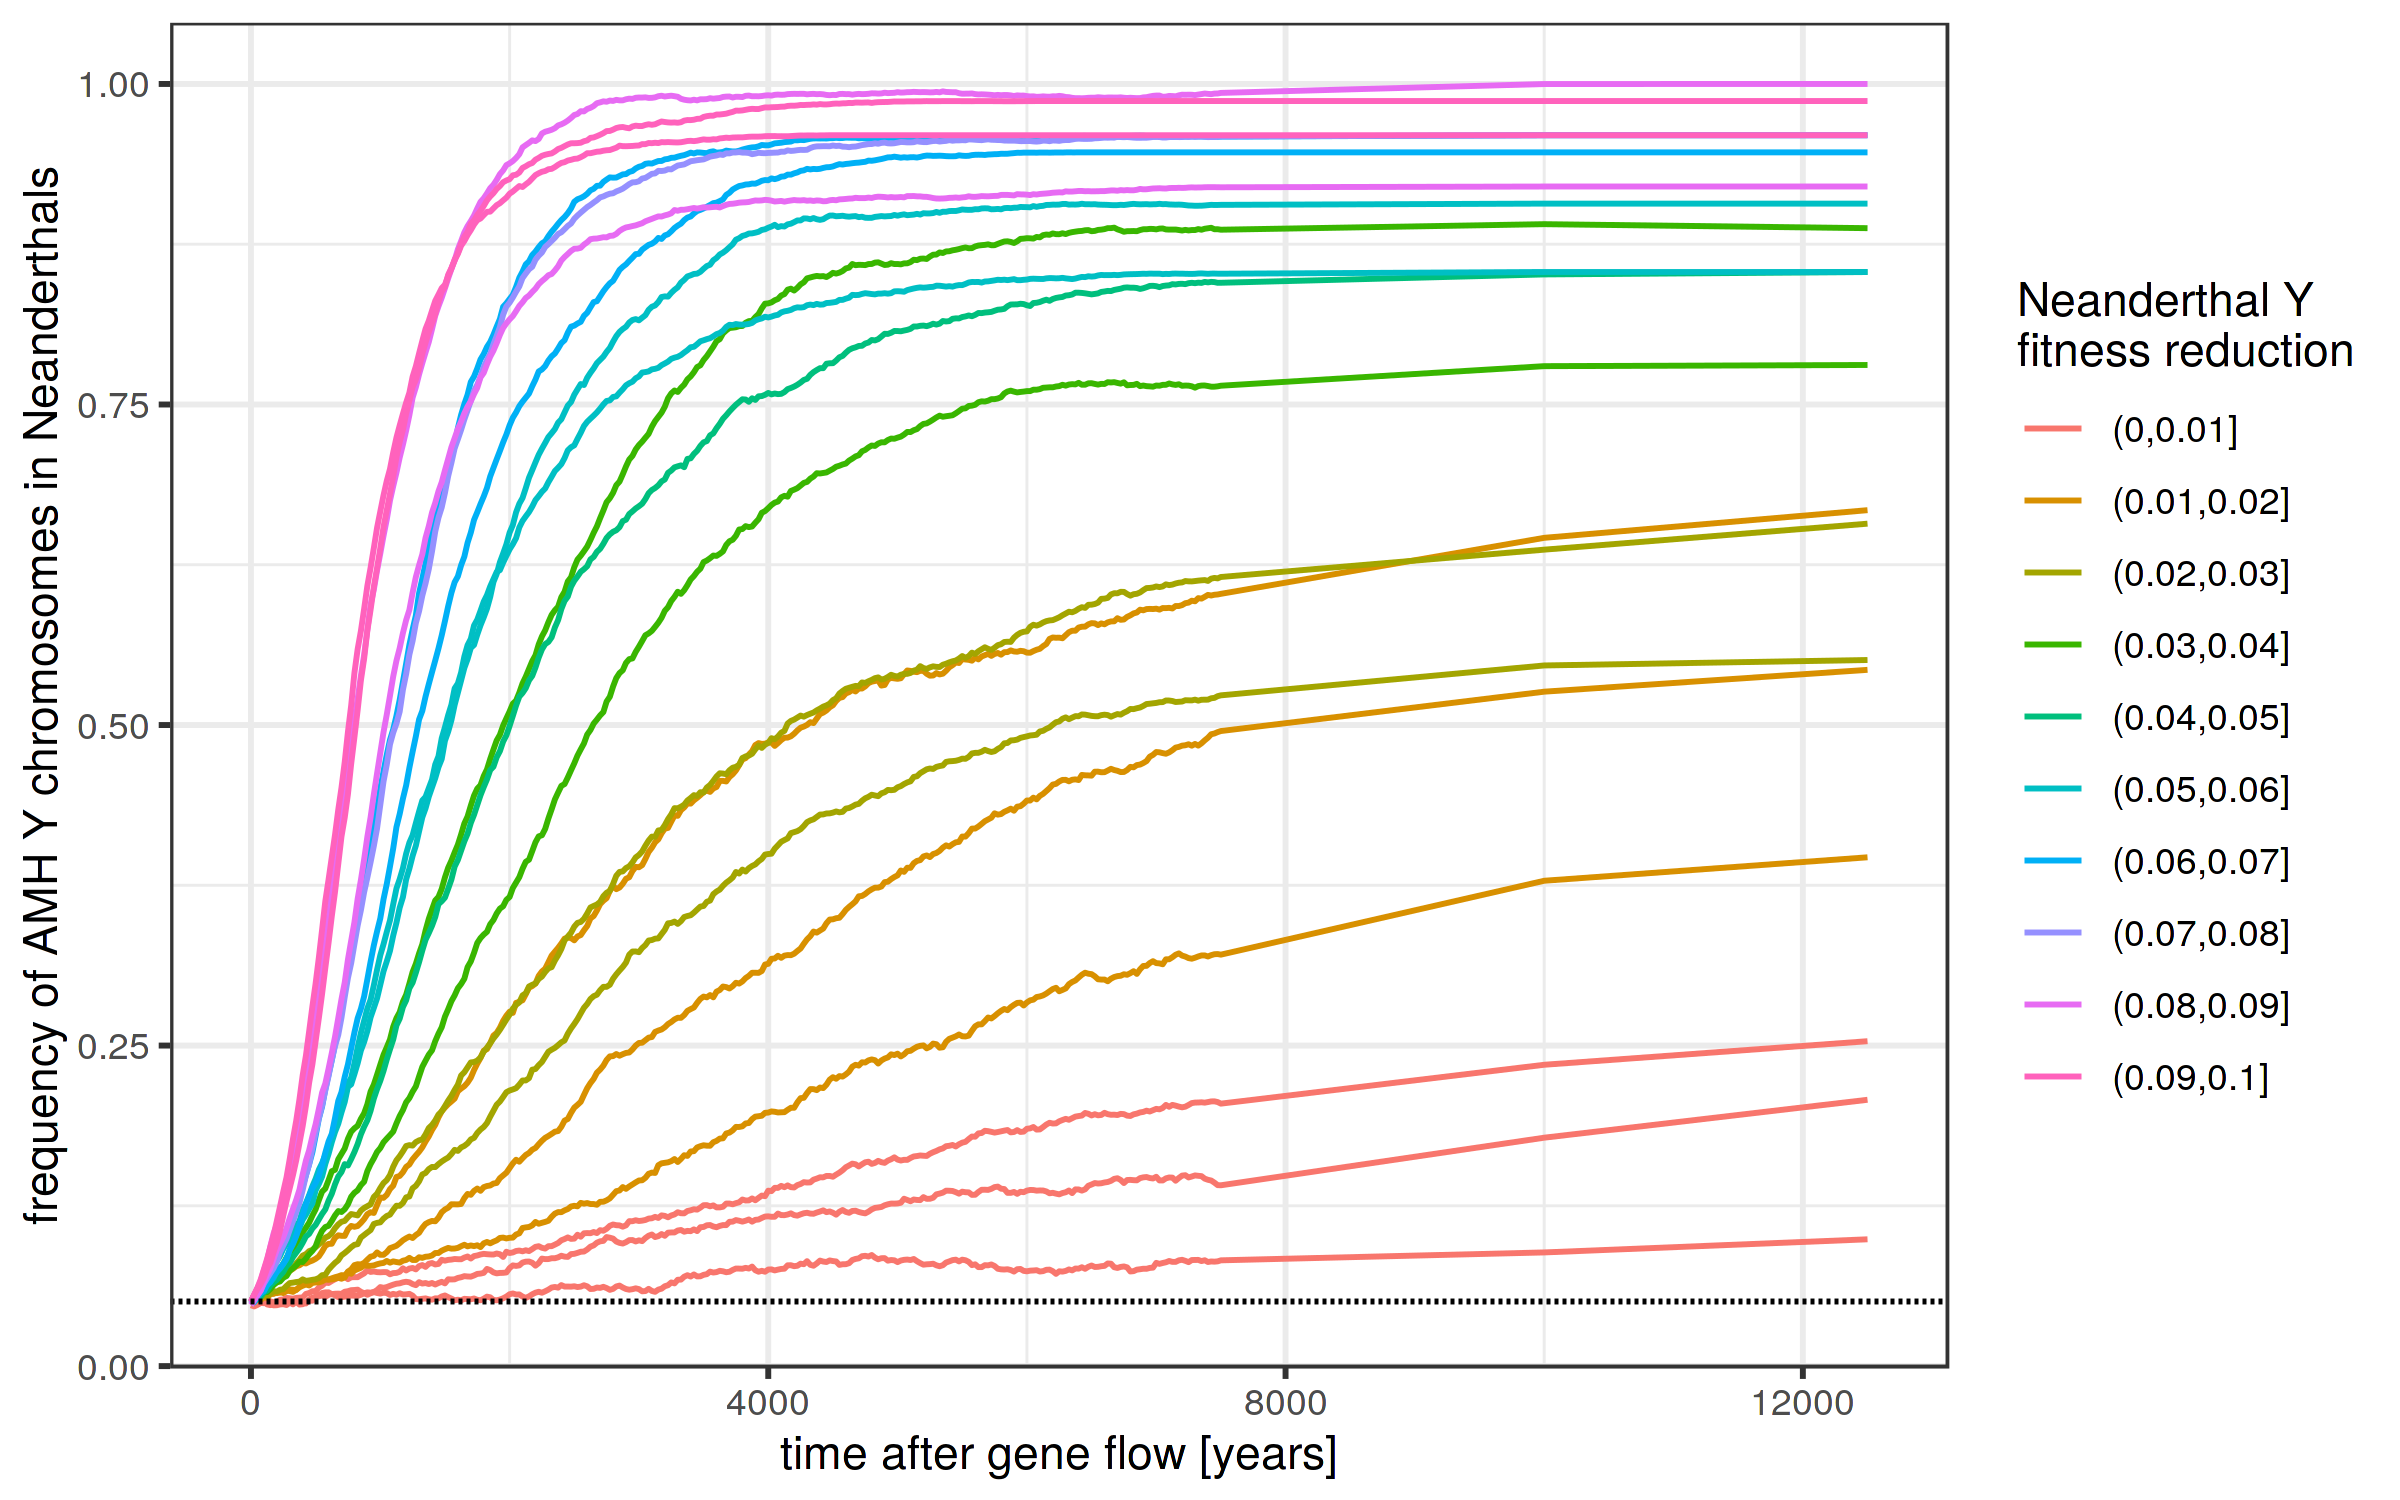

In [42]:
set_dim(8, 5)

mean_traj_fitness %>%
filter(admix_time == 300000) %>%
filter(gen < 600) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    geom_hline(yintercept = 0.05, linetype = 2) +
    theme_bw() +
    labs(color = "Neanderthal Y\nfitness reduction",
         y = "frequency of AMH Y chromosomes in Neanderthals",
         x = "time after gene flow [years]")

In [22]:
prob_traj_fitness <- traj_fitness %>%
    group_by(gen, time, gene_total, admix_time, admix_rate) %>%
    summarise(ancestry = mean(ancestry > 0.95),
              ratio = mean(ratio))

In [23]:
prob_traj_fitness <- prob_traj_fitness %>% mutate(fitness_bin = cut(ratio, boundaries))

In [24]:
prob_traj_fitness %>% head

gen time gene_total admix_time admix_rate ancestry ratio       fitness_bin
1 0   0    100000     200000     0.05       0        0.002629396 (0,0.01]   
2 0   0    100000     225000     0.05       0        0.002822213 (0,0.01]   
3 0   0    100000     250000     0.05       0        0.002826003 (0,0.01]   
4 0   0    100000     275000     0.05       0        0.002536861 (0,0.01]   
5 0   0    100000     300000     0.05       0        0.002363965 (0,0.01]   
6 0   0    100000     325000     0.05       0        0.001794369 (0,0.01]

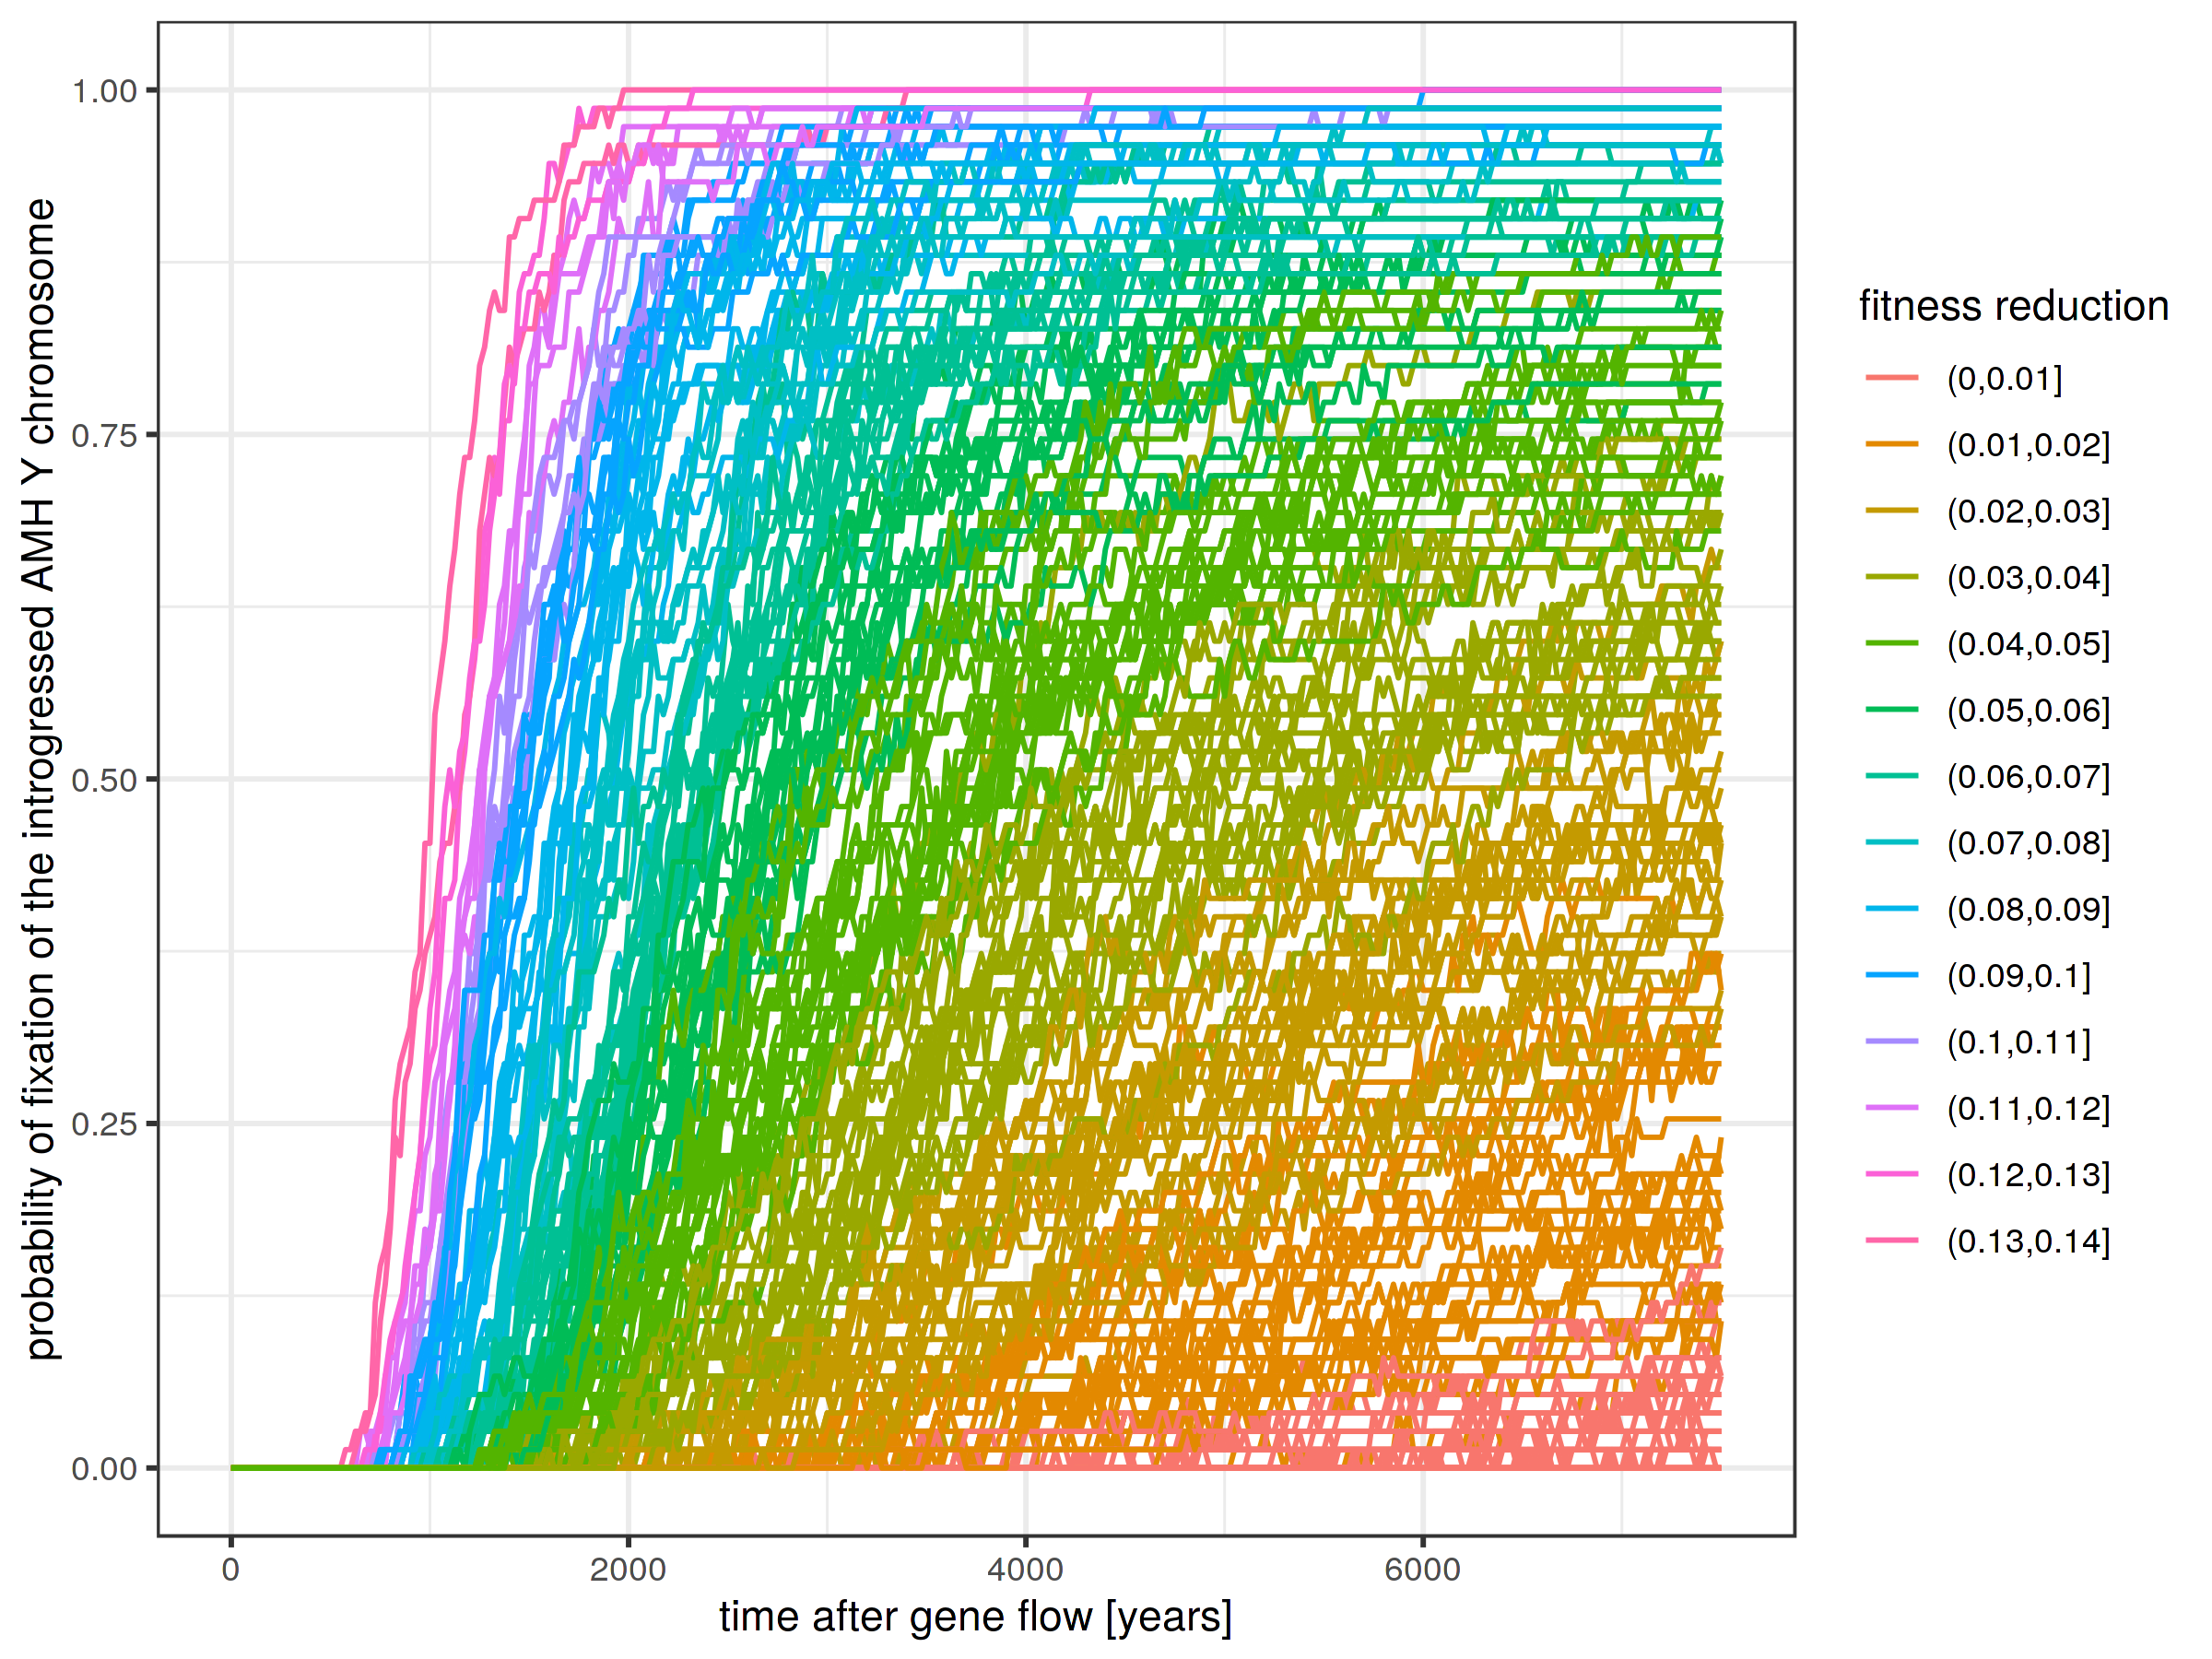

In [25]:
set_dim(8, 6)

prob_traj_fitness %>%
filter(gen < 400) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "probability of fixation of the introgressed AMH Y chromosome",
         x = "time after gene flow [years]")

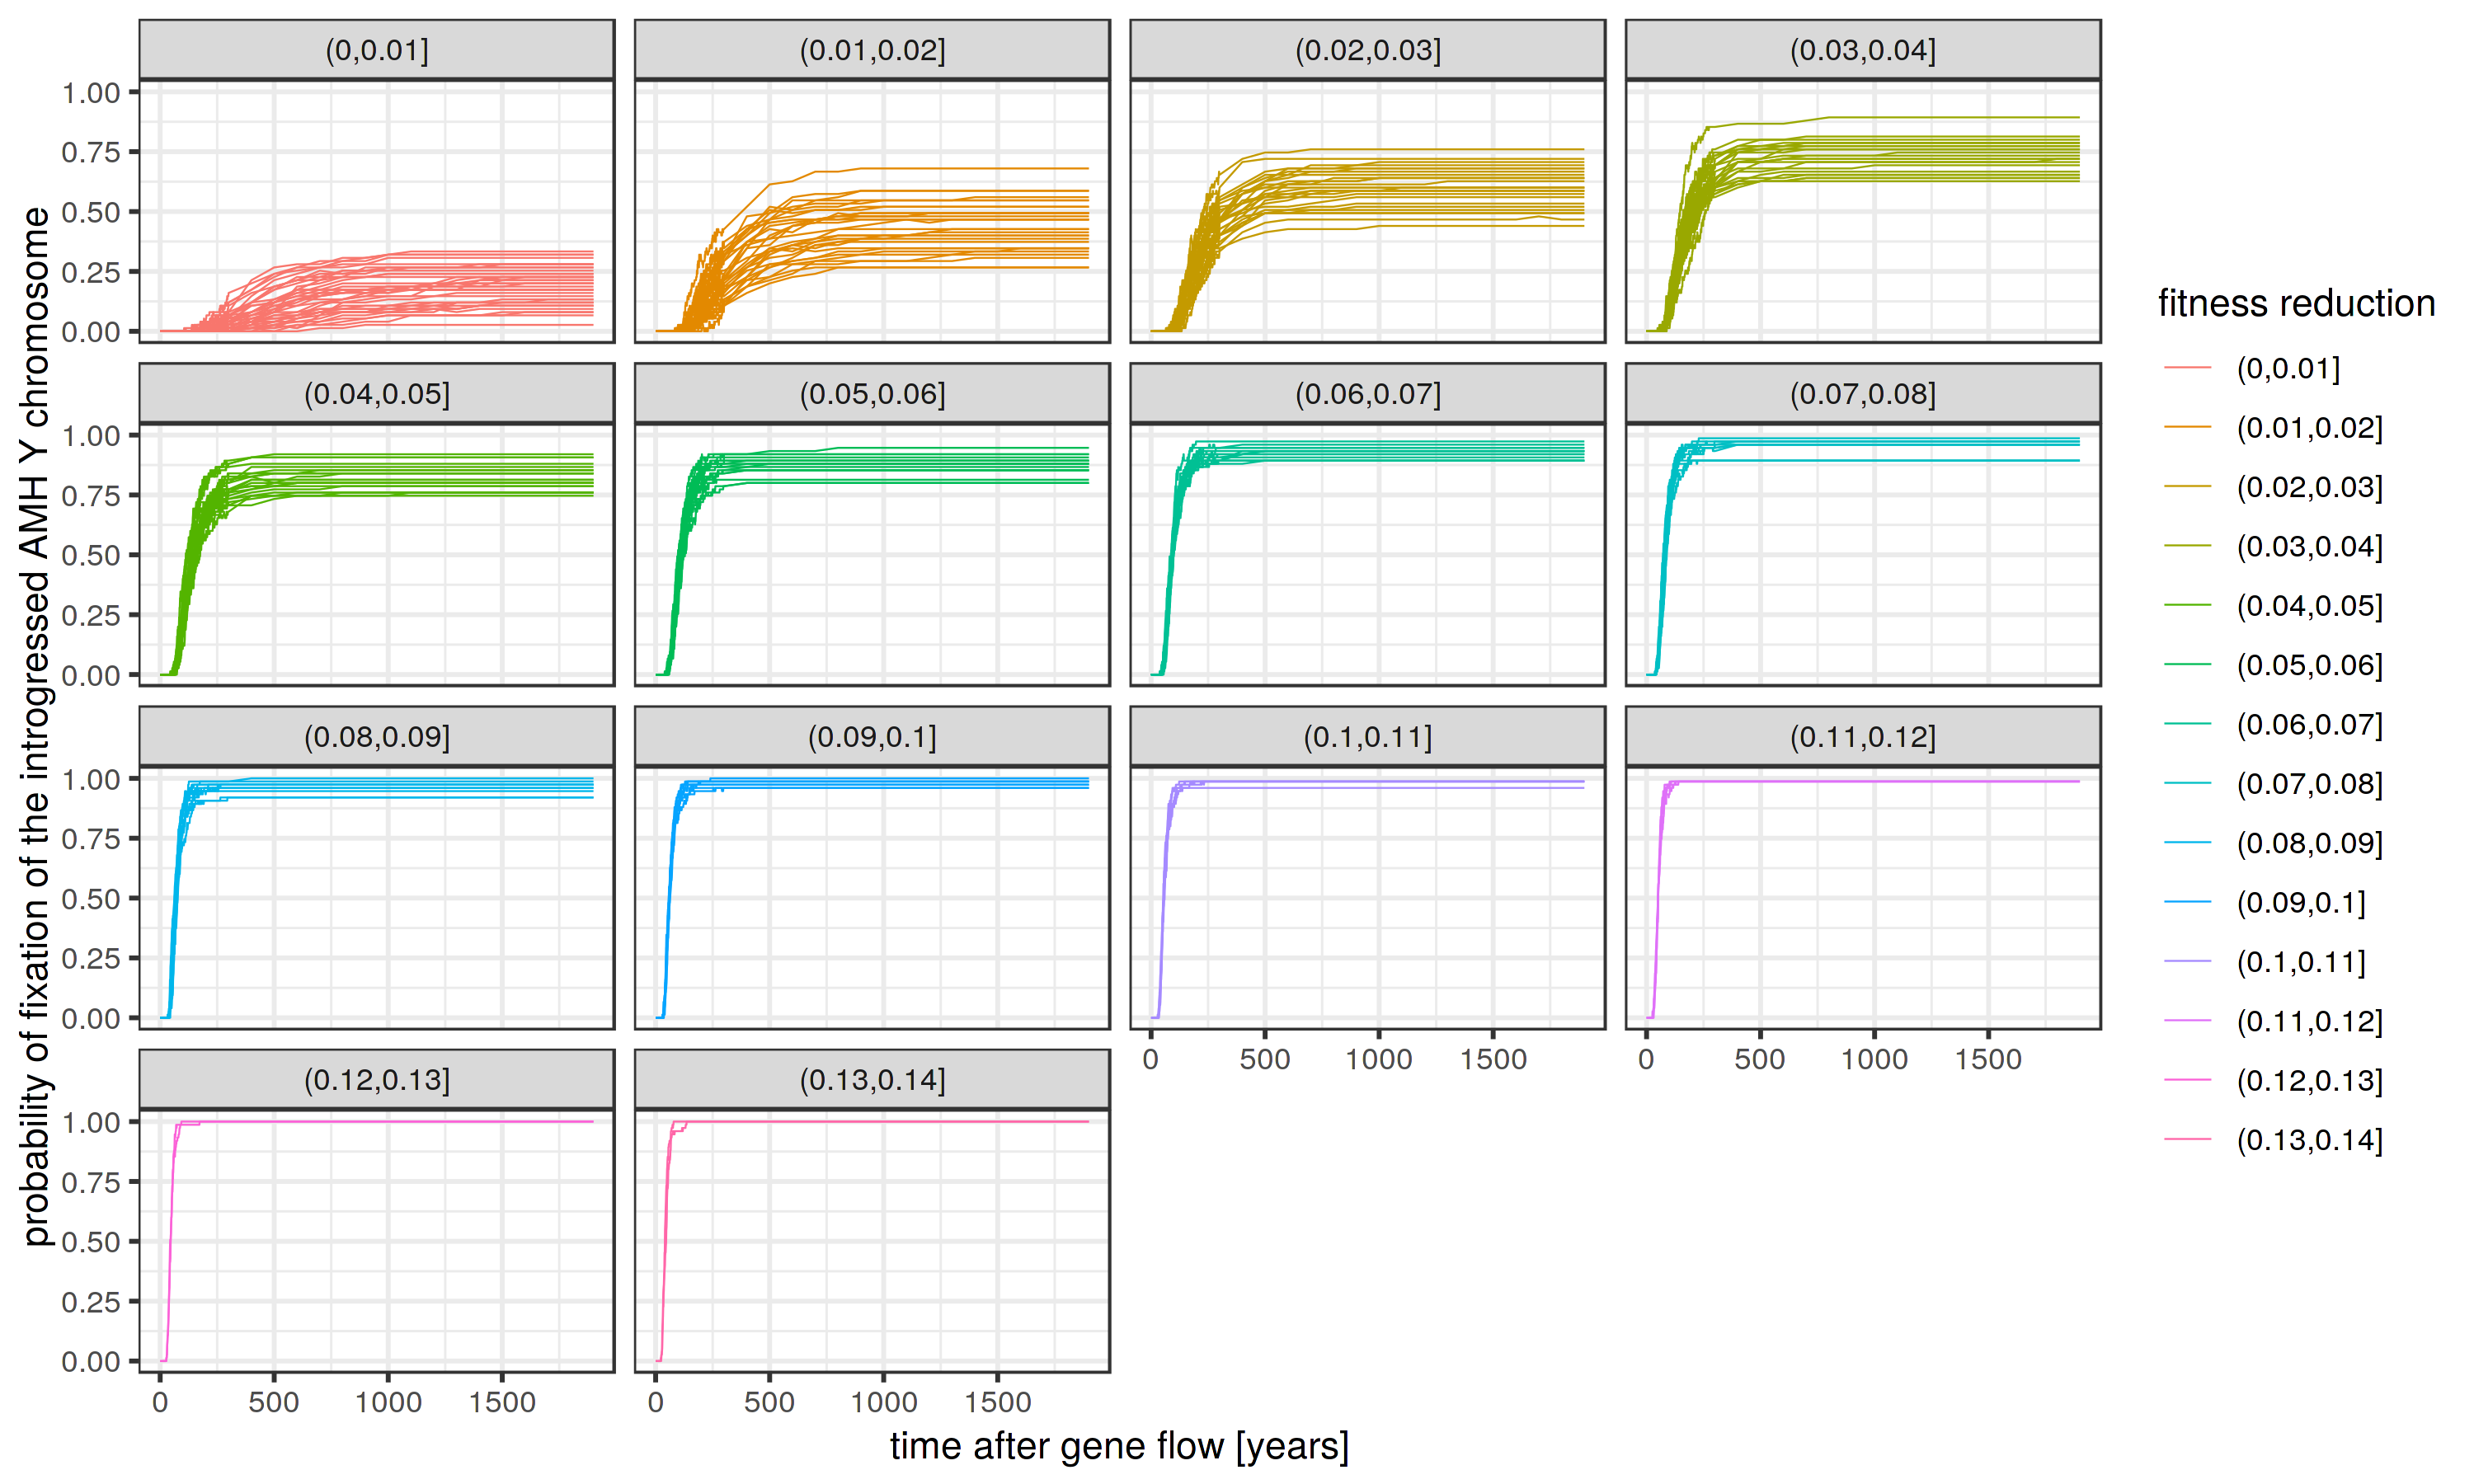

In [26]:
set_dim(10, 6)

prob_traj_fitness %>%
filter(gen < 2000) %>% 
ggplot(aes(gen, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time)), size = 1/5) +
    facet_wrap(~ fitness_bin) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "probability of fixation of the introgressed AMH Y chromosome",
         x = "time after gene flow [years]")

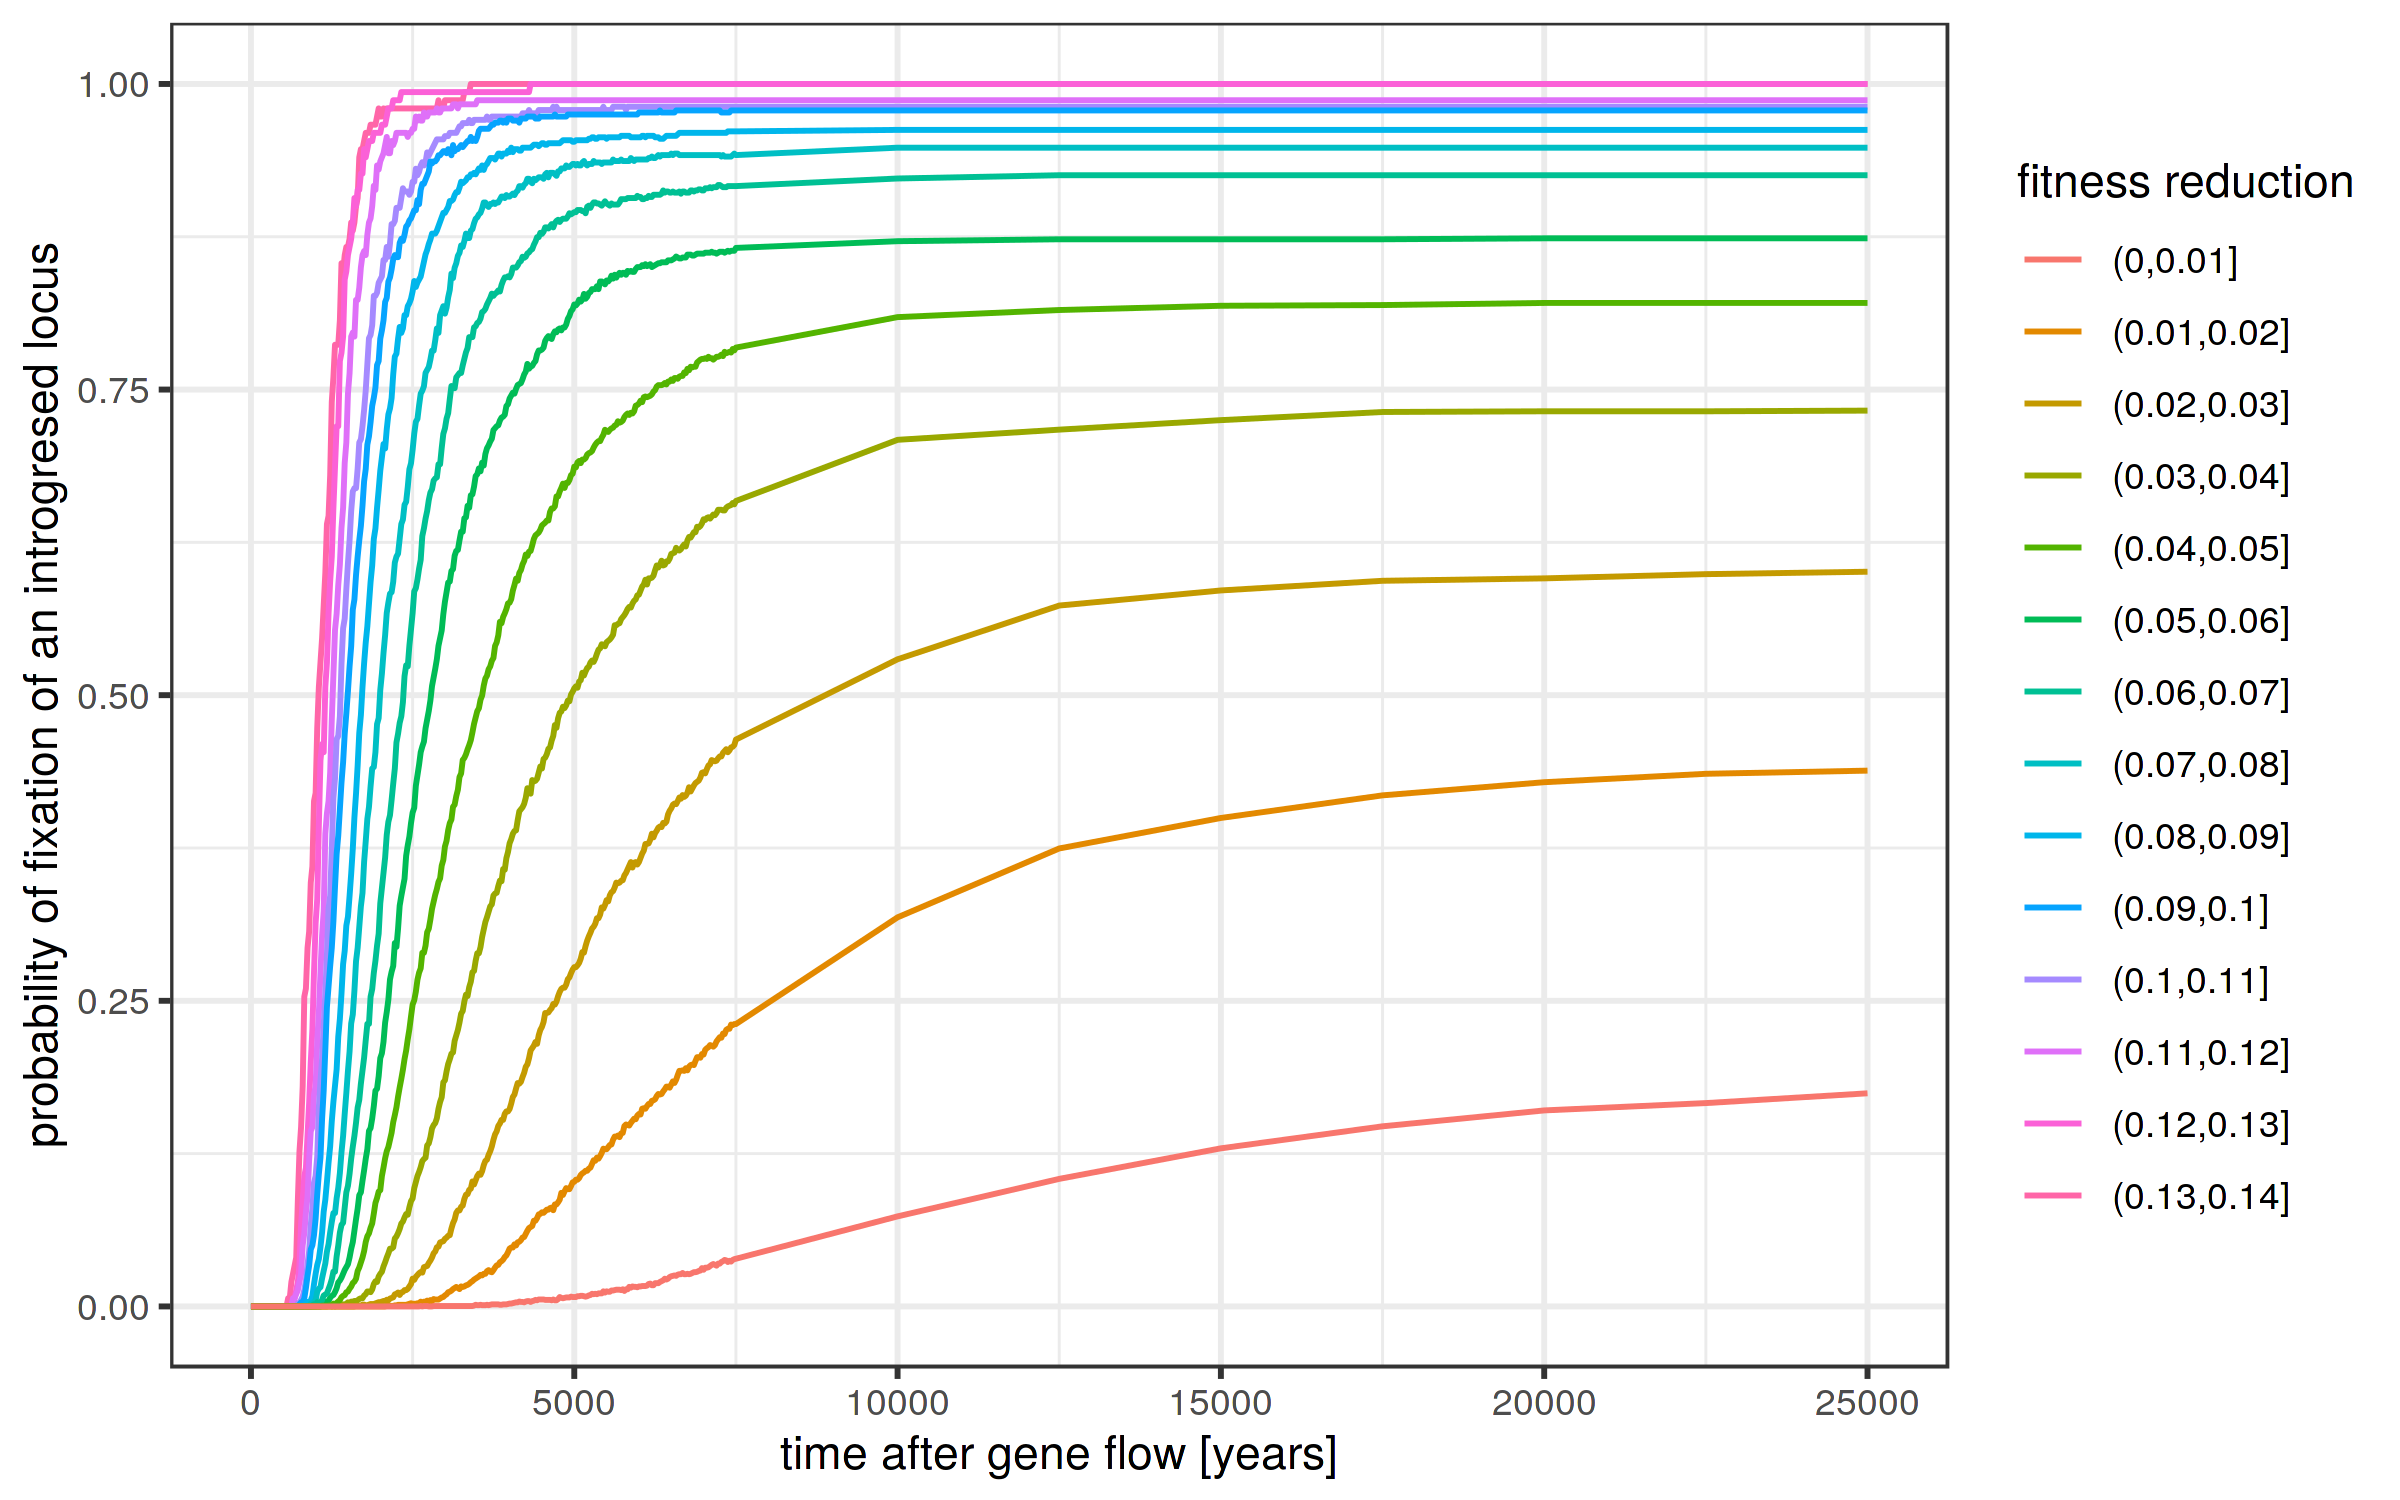

In [32]:
set_dim(8, 5)

prob_traj_fitness %>%
group_by(gen, time, fitness_bin) %>%
summarise_all(mean) %>%
filter(gen <= 1000) %>%
ggplot(aes(time, ancestry, color = fitness_bin)) +
    geom_line(aes(group = interaction(gene_total, admix_time))) +
    theme_bw() +
    labs(color = "fitness reduction",
         y = "probability of fixation of an introgresed locus",
         x = "time after gene flow [years]")

In [28]:
P <- function(s, p = 0.05, Ne = 500) (1 - exp(-2*Ne*s*p) / (1 - exp(-2*Ne*s)))

In [29]:
prob_theory <- tibble(
    s = seq(0.01, 0.14, 0.01) - 0.005,
    fitness_bin = factor(glue("({s - 0.005},{s + 0.005}]")),
    time = "theory",
)

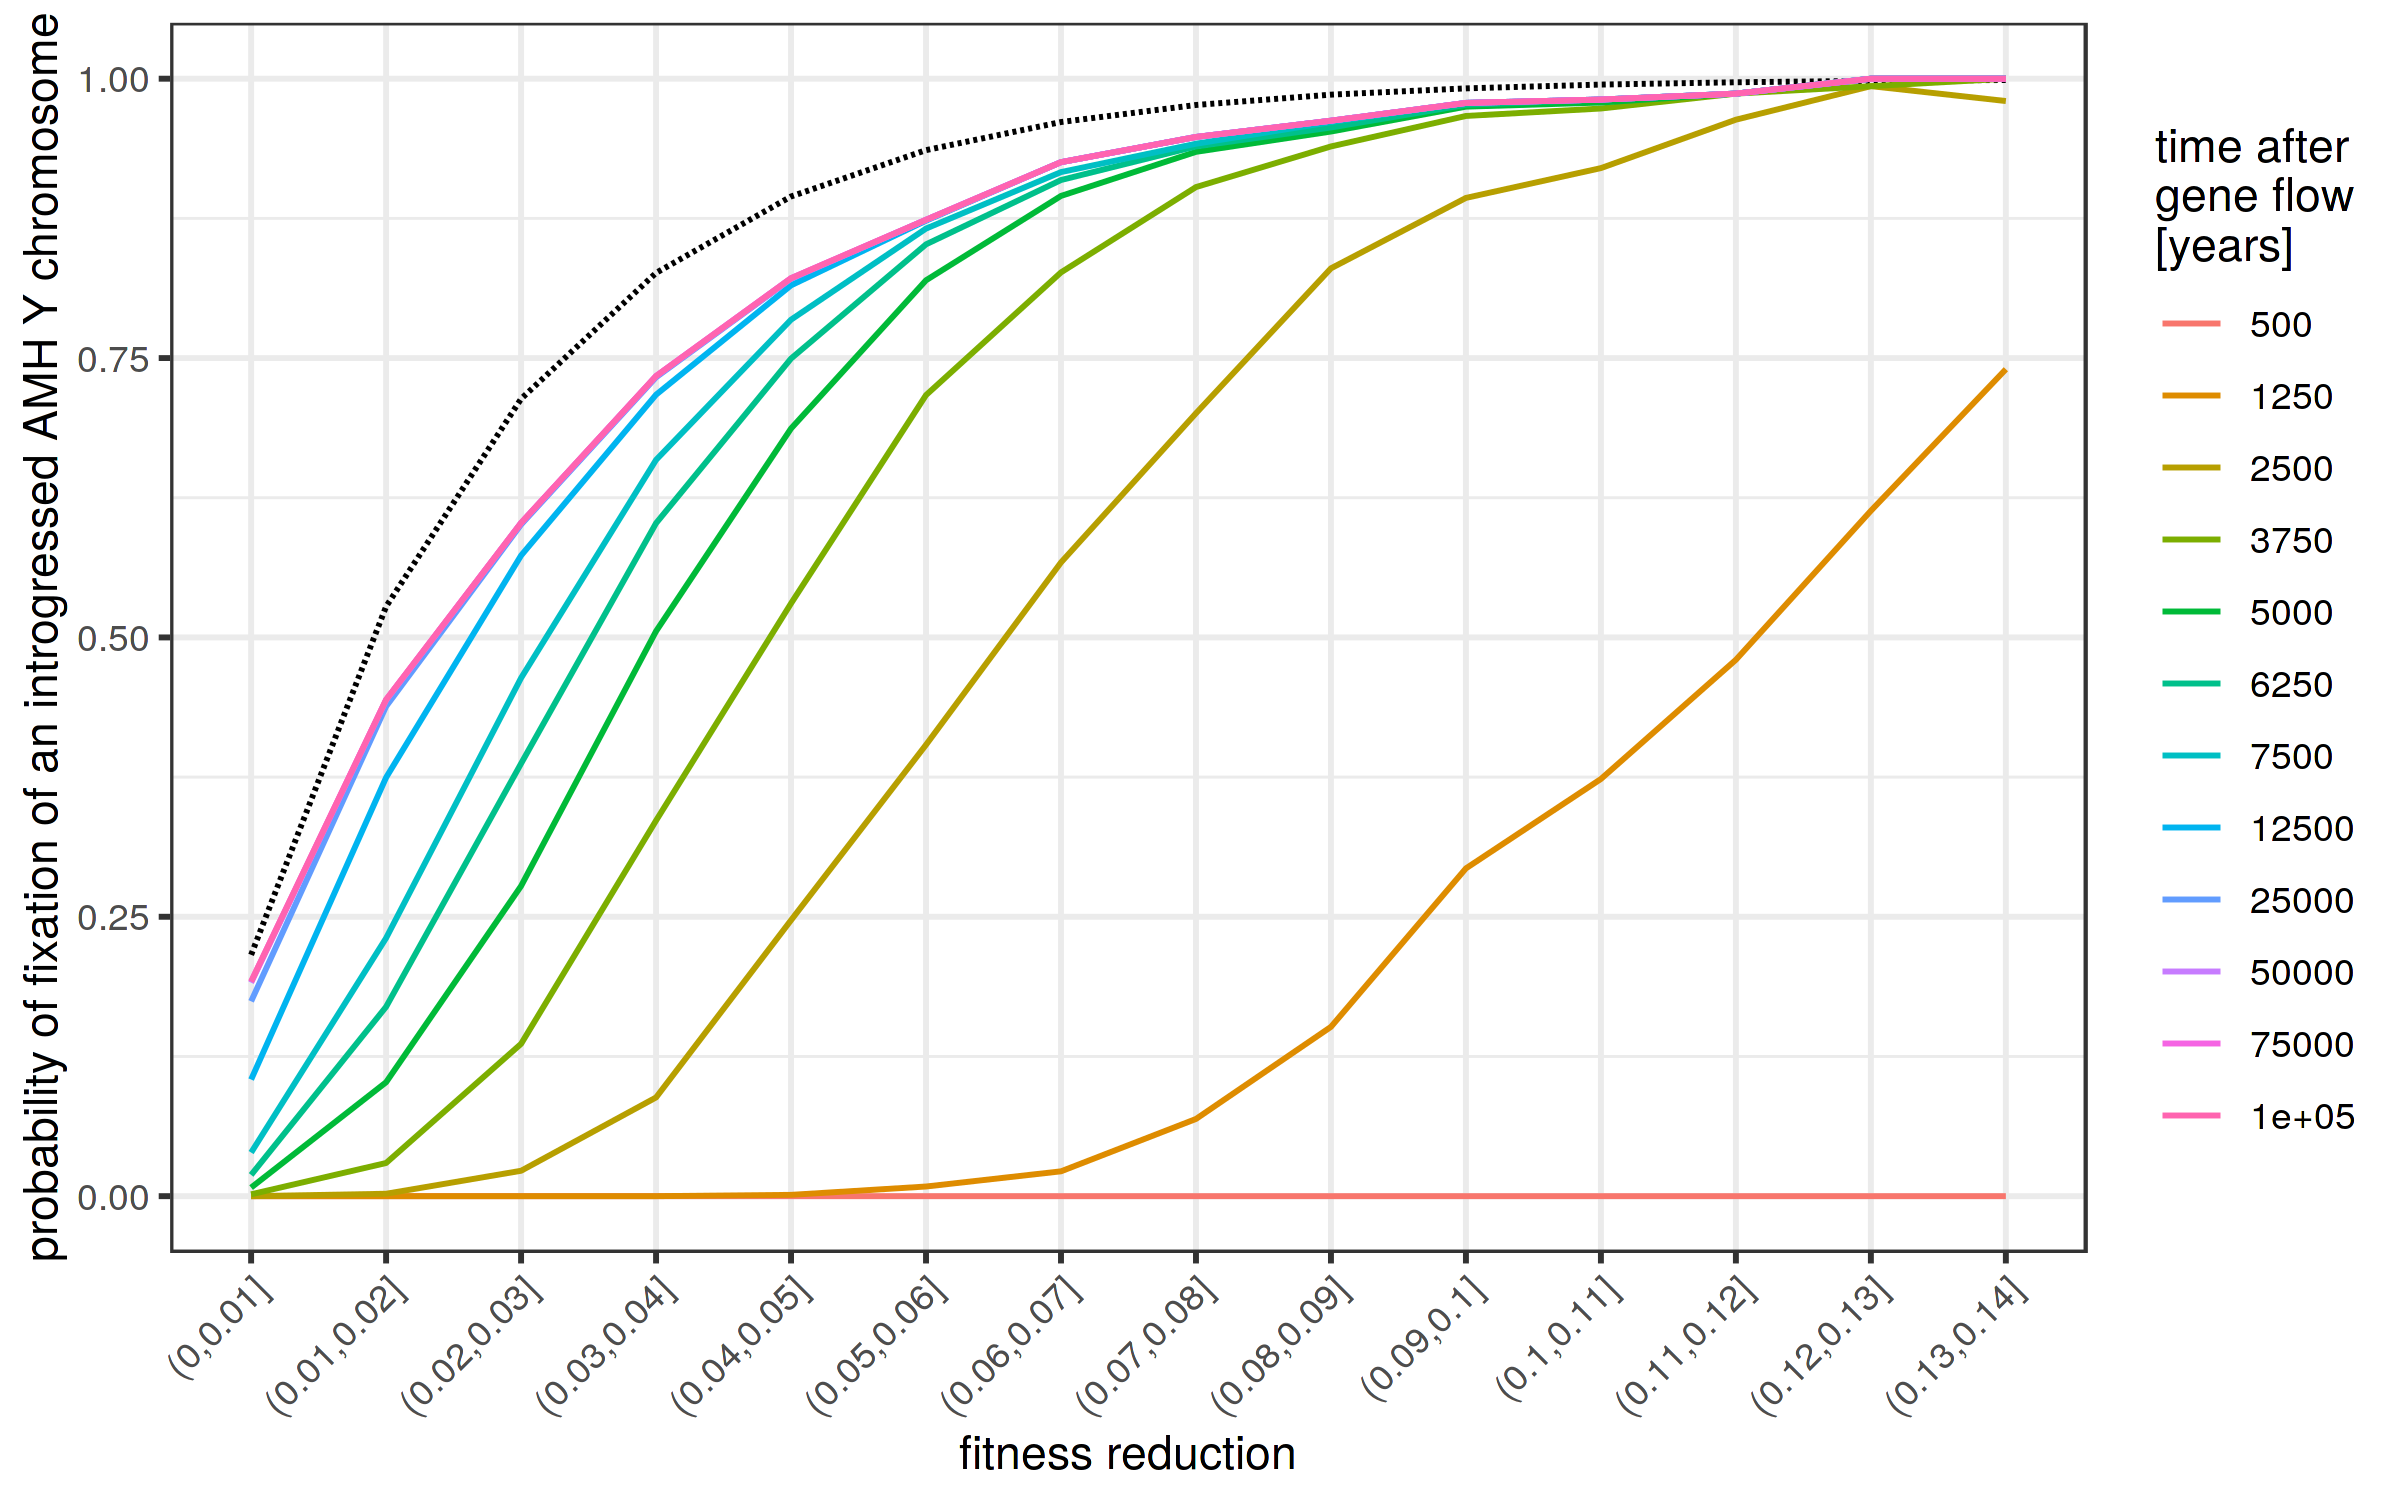

In [30]:
set_dim(8, 5)

prob_traj_fitness %>%
group_by(gen, time, fitness_bin) %>%
summarise_all(mean) %>%
filter(gen %in% c(20, 50, 100, 150, 200, 250, 300, 500, 1000, 2000, 3000, 4000)) %>%
ggplot(aes(fitness_bin, ancestry,
           color = factor(time),
           group = factor(time))) +
    geom_line(data = prob_theory, aes(fitness_bin, P(s, p = 0.05, Ne = 500)),
              color = "black", linetype = 2, size = 1/2) +
    geom_line() +
    ylim(0, 1) +
    theme_bw() +
    labs(x = "fitness reduction",
         y = "probability of fixation of an introgressed AMH Y chromosome",
         color = "time after\ngene flow\n[years]") +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))

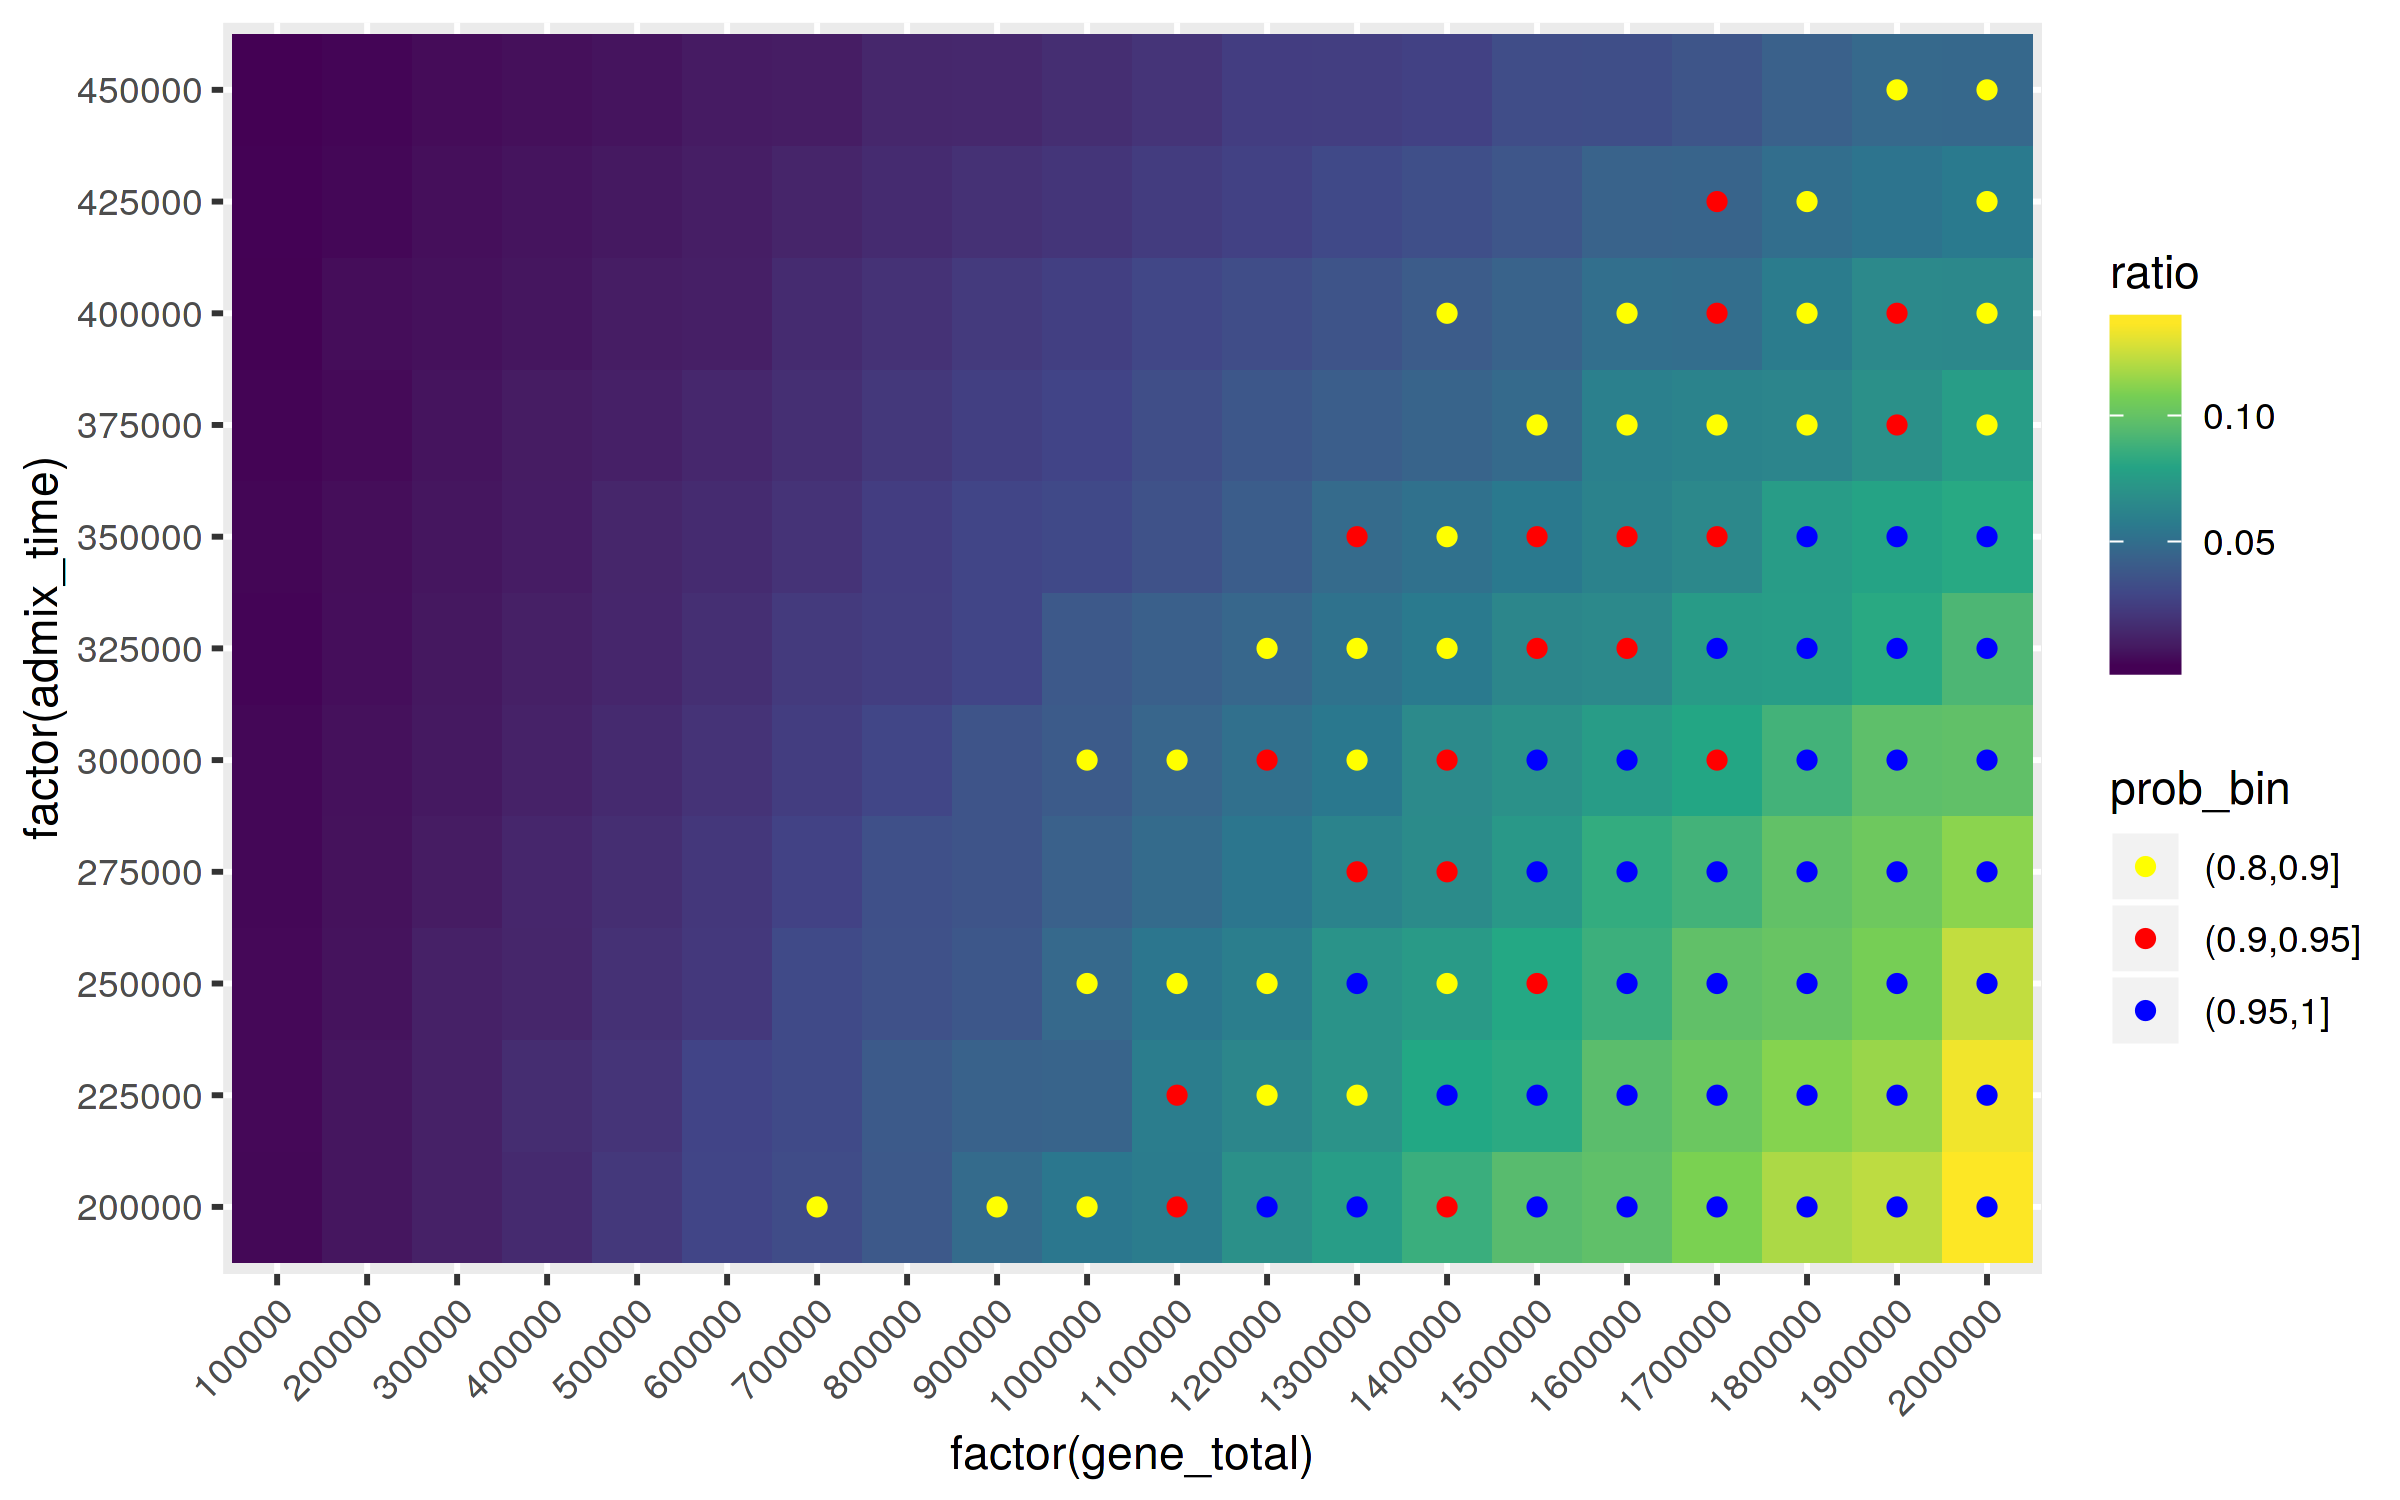

In [31]:
prob_traj_fitness %>%
filter(time == 100000) %>%
mutate(prob_bin = cut(ancestry, c(0, 0.8, 0.9, 0.95, 1))) %>% {
ggplot(data = ., aes(factor(gene_total), factor(admix_time), fill = ratio)) +
    geom_tile() +
    geom_point(data = filter(., prob_bin != "(0,0.8]"), aes(color = prob_bin)) +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    scale_fill_viridis_c() +
    scale_color_manual(values = c("yellow", "red", "blue"))
}